In [2]:
%%capture
!pip install ../input/pandasta/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/pandasta/pandas_ta-0.3.14b0-py3-none-any.whl
!pip install arch

import pandas_ta as ta

from arch import arch_model
from arch.unitroot import PhillipsPerron

In [3]:
%%capture
!pip install einops

In [21]:
import os
import gc
import ast

import numpy as np
import pandas as pd 


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, bds, kpss

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import genextreme as gev 

from random import choices, choice, randint, random

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import lightgbm as lgb

import torch
from einops import rearrange, einsum

from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 10
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

pd.set_option('display.max_columns', 500)

# Price graphs

In [5]:
prices = pd.read_csv('/kaggle/input/bybit-trades-accumulated/index.csv')
prices.index = pd.to_datetime(prices['start_at'], unit='s')
prices.drop(['period', 'year', 'month', 'day', 'symbol', 'start_at'], inplace=True, axis=1)
display(prices)

price = prices['open']

,open,high,low,close
start_at,,,,
2020-03-25 00:00:00,6768.65,6768.65,6743.12,6745.30
2020-03-25 00:01:00,6745.30,6745.73,6680.09,6700.39
2020-03-25 00:02:00,6700.39,6719.09,6698.38,6707.20
2020-03-25 00:03:00,6707.20,6713.03,6692.53,6693.64
2020-03-25 00:04:00,6693.64,6710.13,6693.01,6710.13
...,...,...,...,...
2023-02-28 23:55:00,23127.51,23128.25,23120.26,23122.79
2023-02-28 23:56:00,23122.79,23124.40,23120.44,23123.53
2023-02-28 23:57:00,23123.53,23135.59,23123.53,23125.47


count     1071.00
mean      1650.65
std       1535.50
min         69.94
25%        506.22
50%       1235.41
75%       2358.40
max      13117.81
dtype: float64

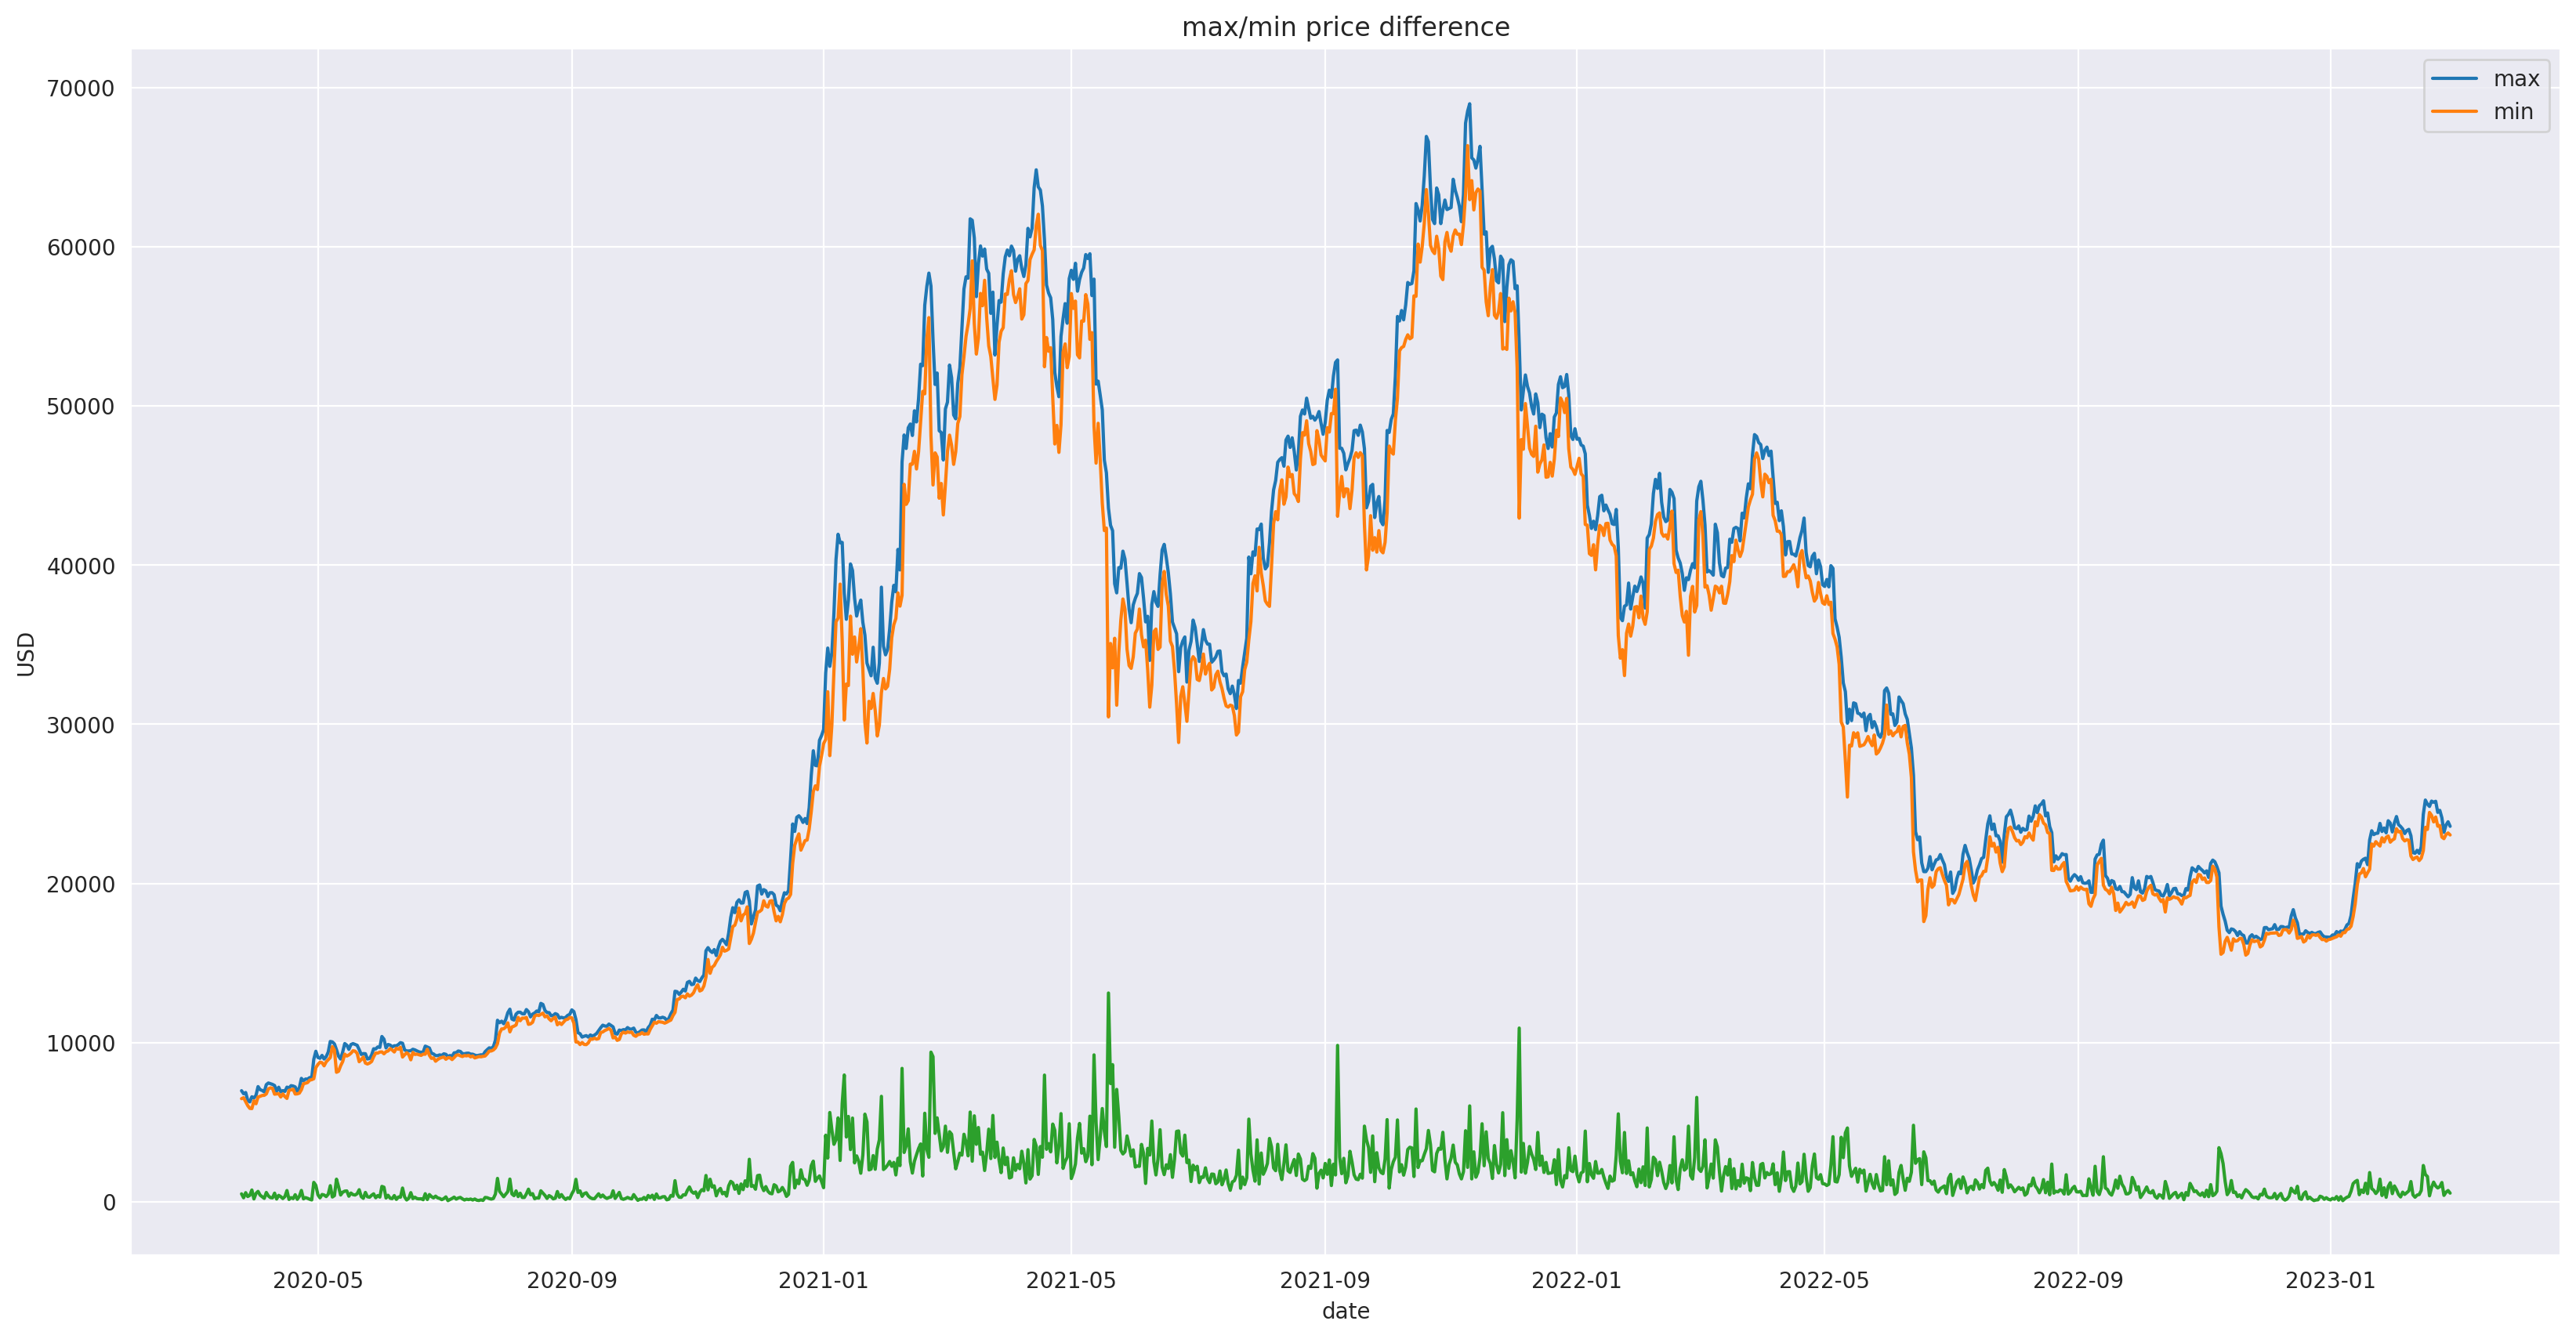

In [6]:
daily_prices = prices.groupby(prices.index.date).last()

gaps = price.groupby(prices.index.date).agg(['max', 'min']).rename({'max': 'max_price', 'min': 'min_price'})
gaps.plot(figsize=(20, 10), xlabel='date', ylabel='USD', title='max/min price difference')

difference = gaps['max'] - gaps['min']
difference.plot()

display(difference.describe().round(2))

count    1071.00
mean        5.12
std         3.50
min         0.41
25%         2.82
50%         4.28
75%         6.23
max        35.45
dtype: float64

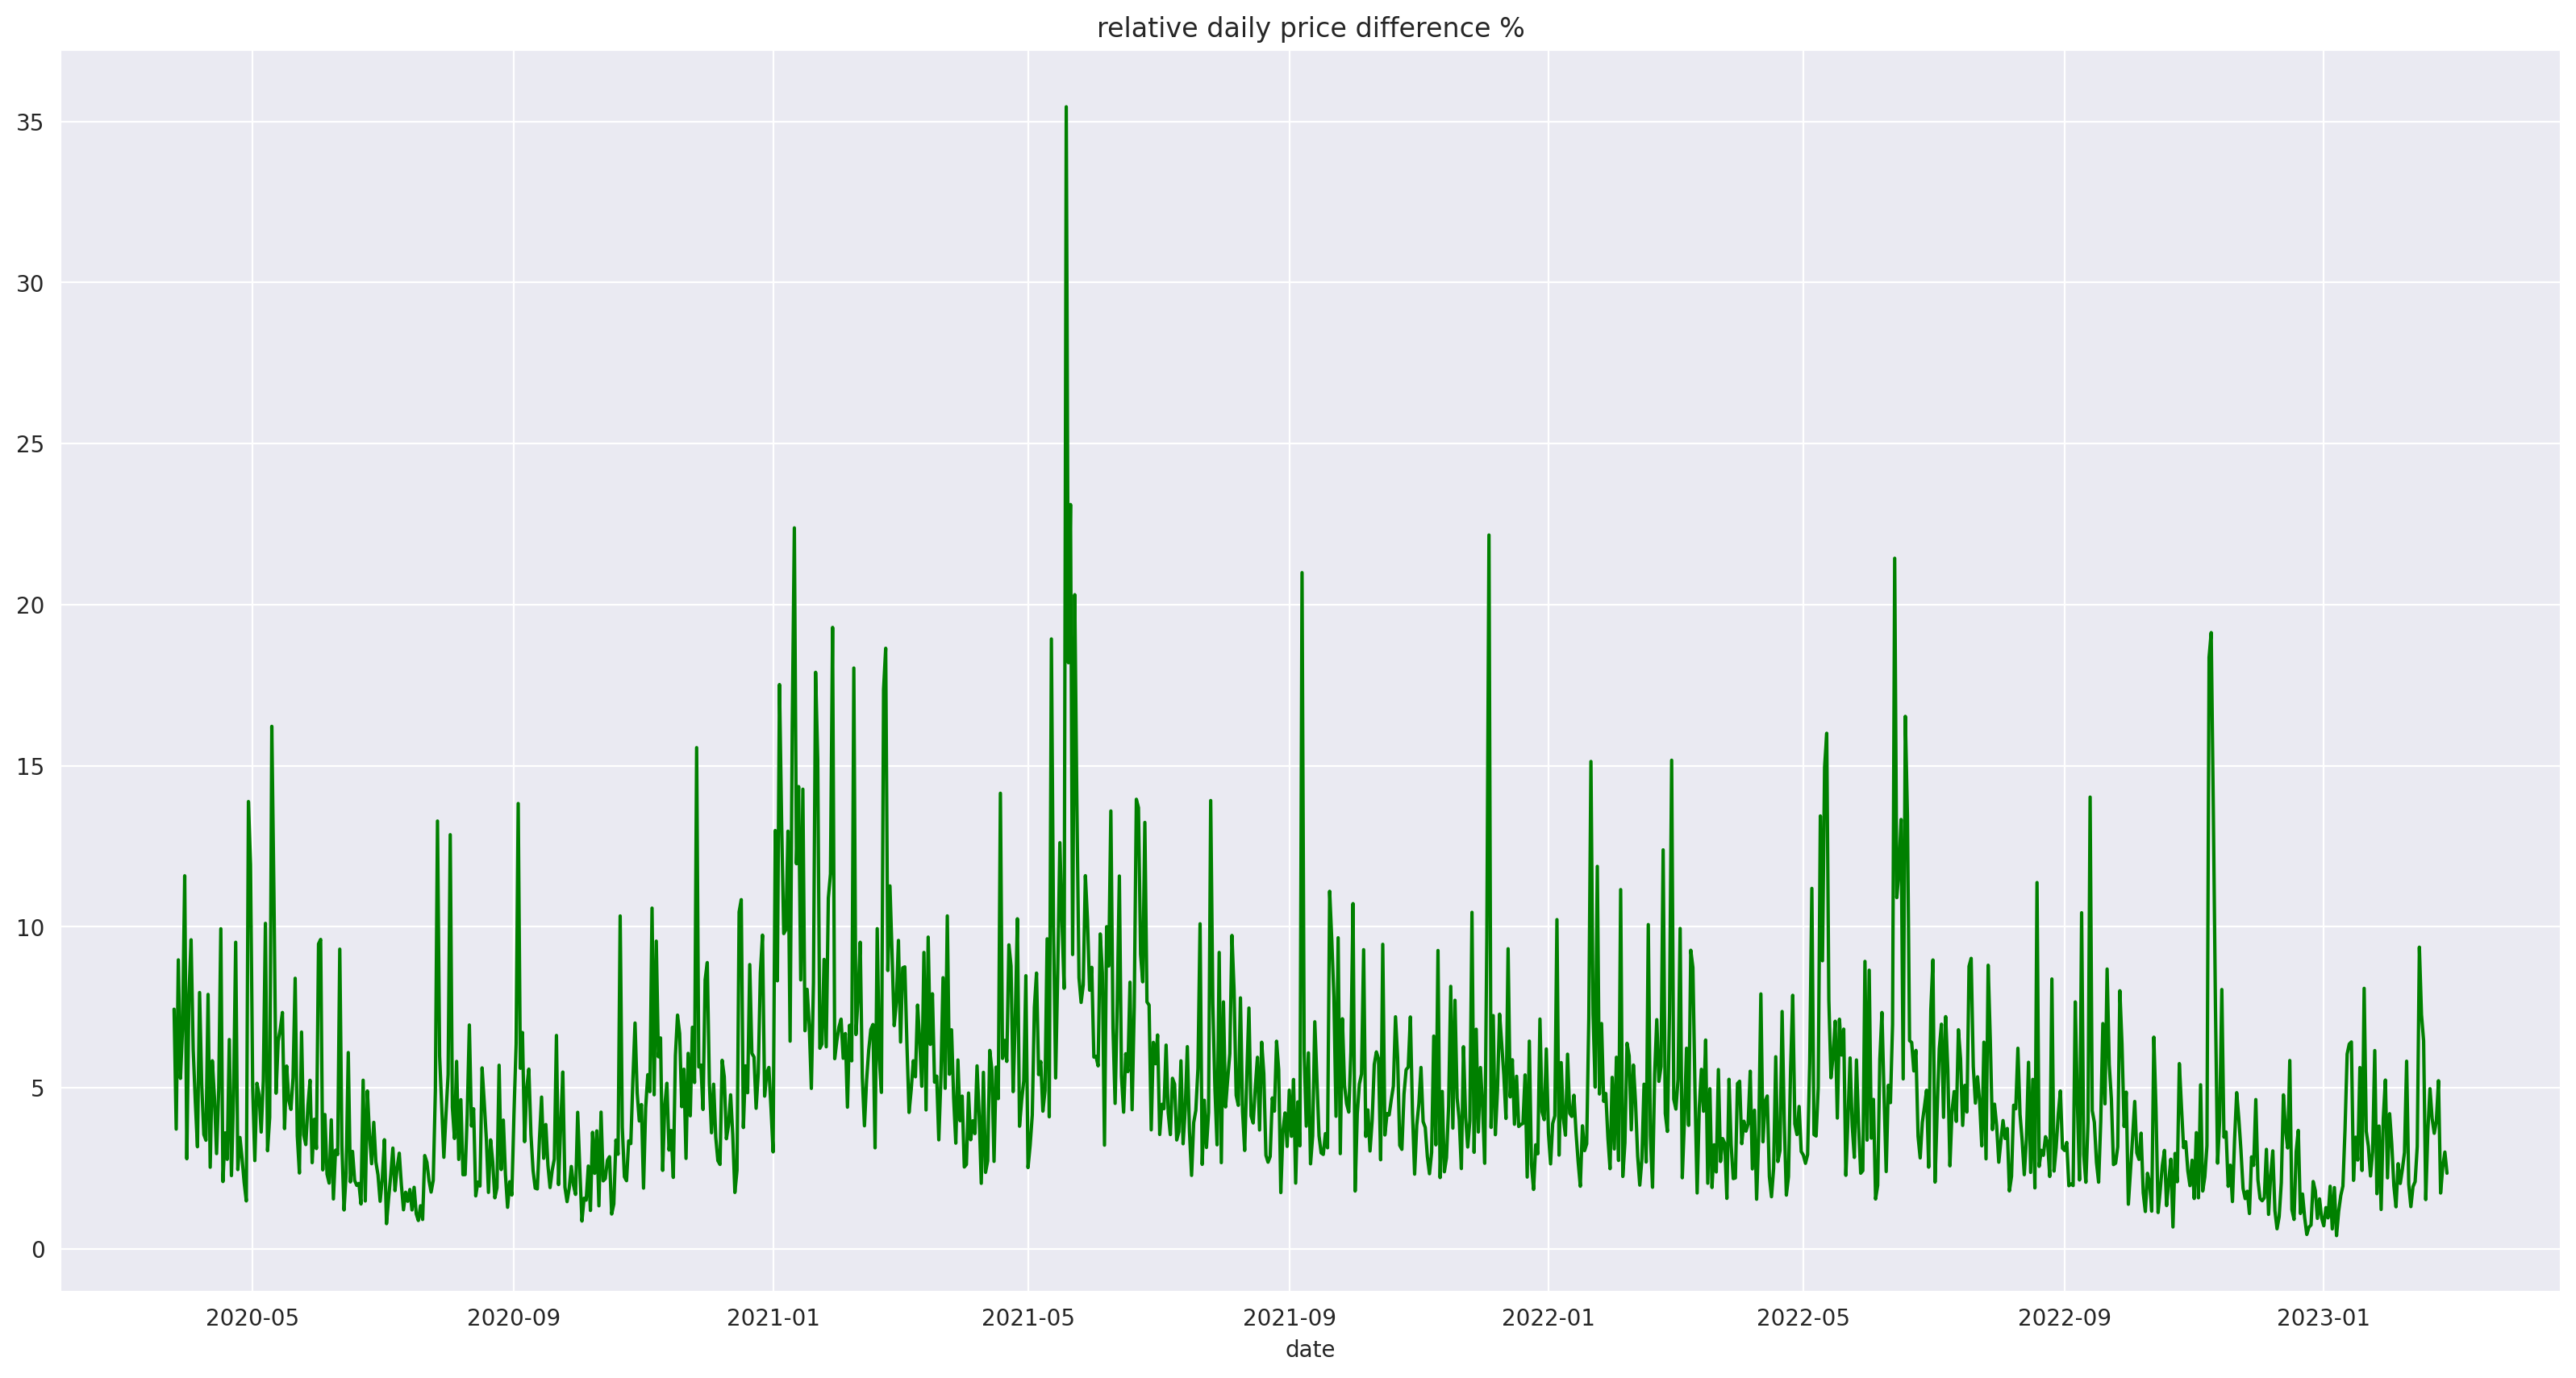

In [7]:
rel_difference = (difference / price.groupby(price.index.date).last() * 100)
display(rel_difference.describe().round(2))
rel_difference.plot(figsize=(20, 10), title='relative daily price difference %', xlabel='date', color='green');

## Moving average

<AxesSubplot: title={'center': 'Simple moving averages'}, xlabel='date'>

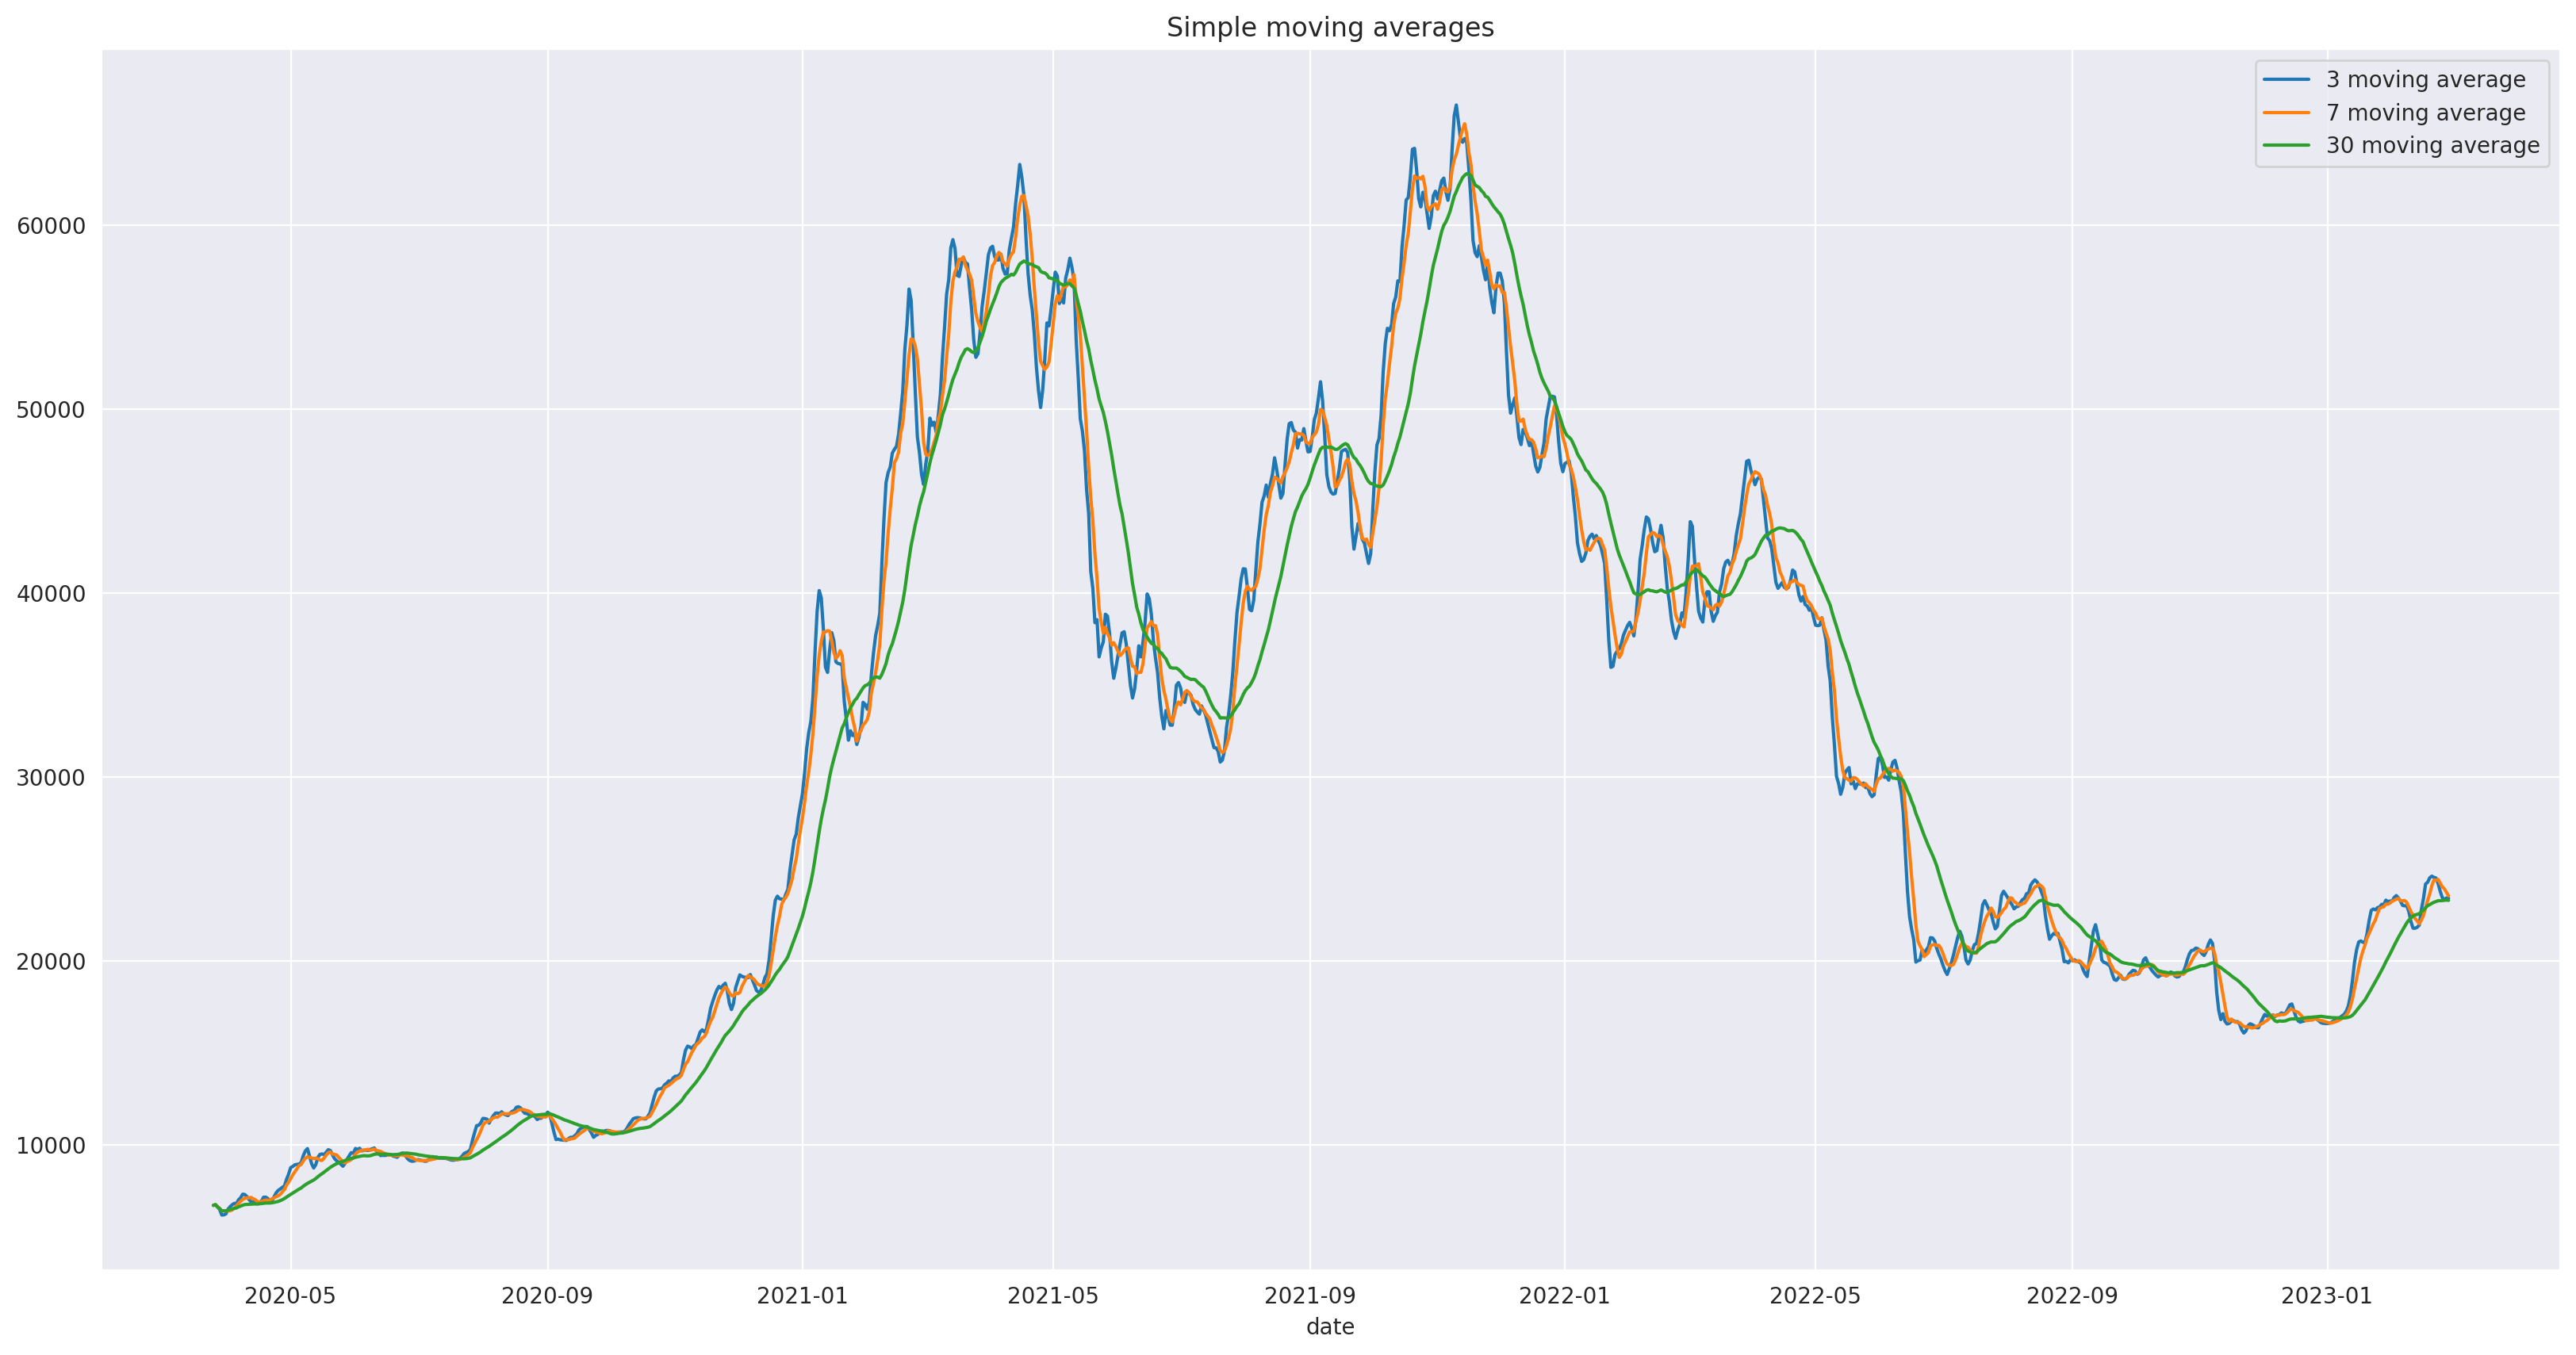

In [8]:
periods = [3, 7, 30]
ma = pd.DataFrame(index=daily_prices.index)
for period in periods:
    ma[f'{period} moving average'] = daily_prices["open"].rolling(period, min_periods=1).mean()

ma.plot(figsize=(20, 10), title='Simple moving averages', xlabel='date')

## finite differences

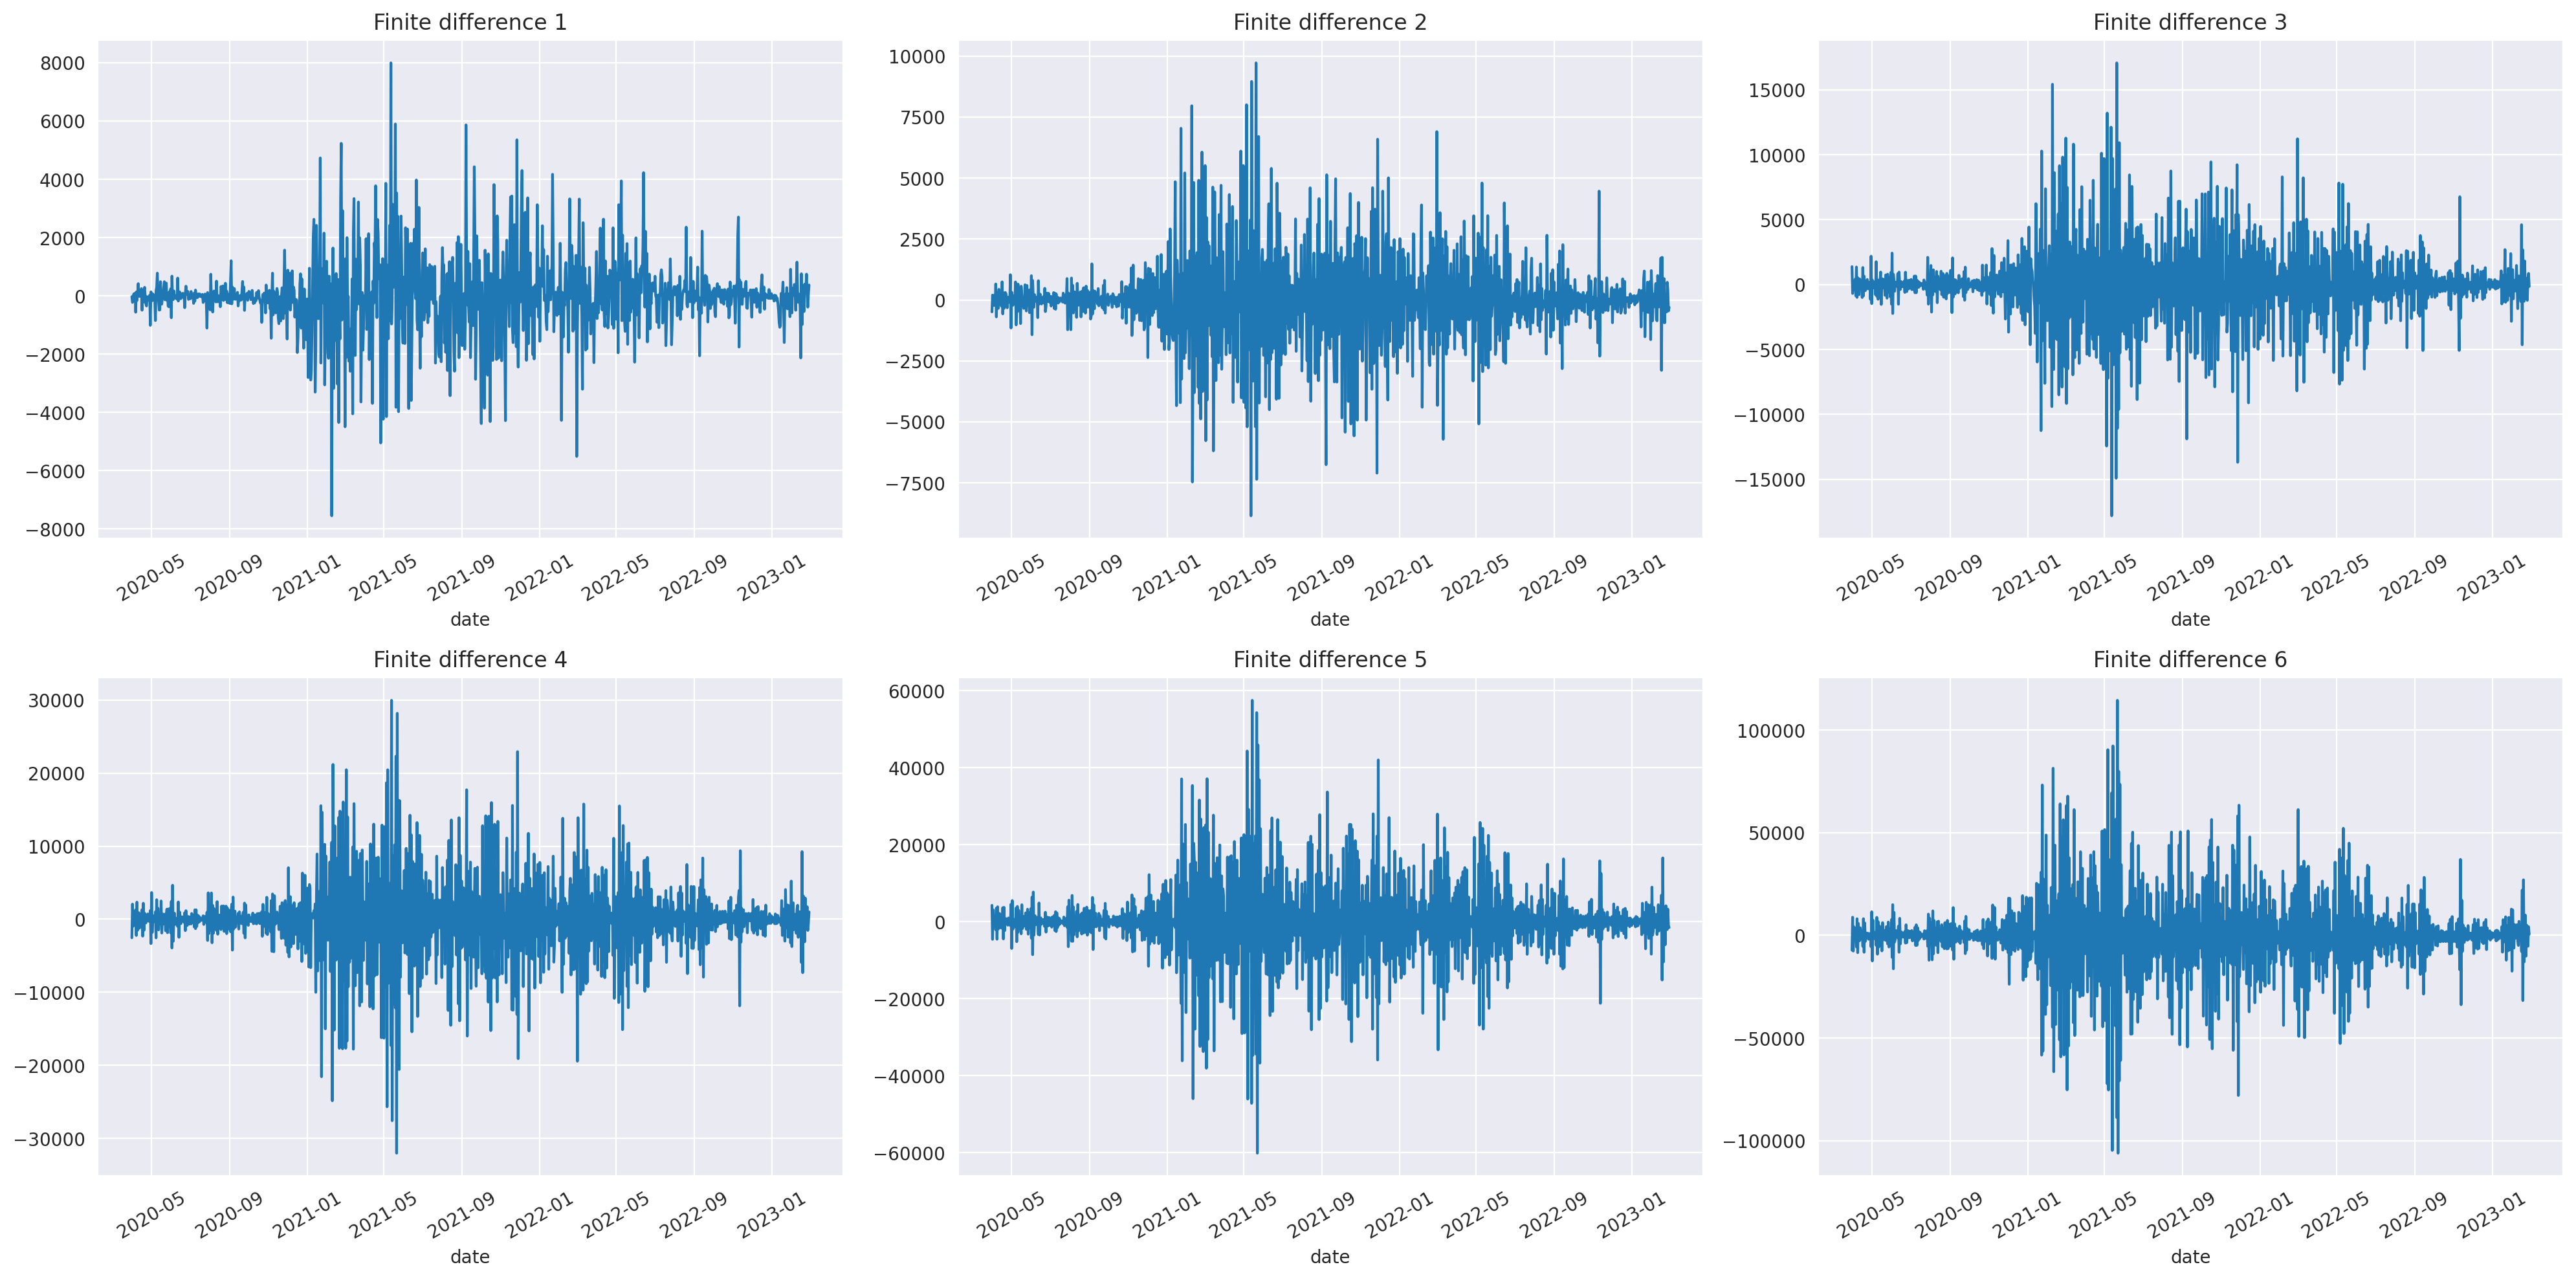

In [9]:
ndiffs = 6

diffs = pd.DataFrame(index=daily_prices.index) 
diff = daily_prices['open']
for idx in range(ndiffs):
    diff = (diff.shift(1) - diff).dropna()
    diffs[f'Finite difference {idx+1}'] = diff
diffs.dropna(inplace=True)

fig, axs = plt.subplots(nrows=2, ncols=ndiffs // 2, figsize=(20, 10))
for idx, col in enumerate(diffs.columns):
    ax = axs[idx // (ndiffs // 2)][idx % (ndiffs // 2)]
    diffs[col].plot(ax=ax, title=col, xlabel='date', rot=30)
    
fig.tight_layout()
plt.show()

# Log returns

<AxesSubplot: title={'center': 'log return series'}, xlabel='date'>

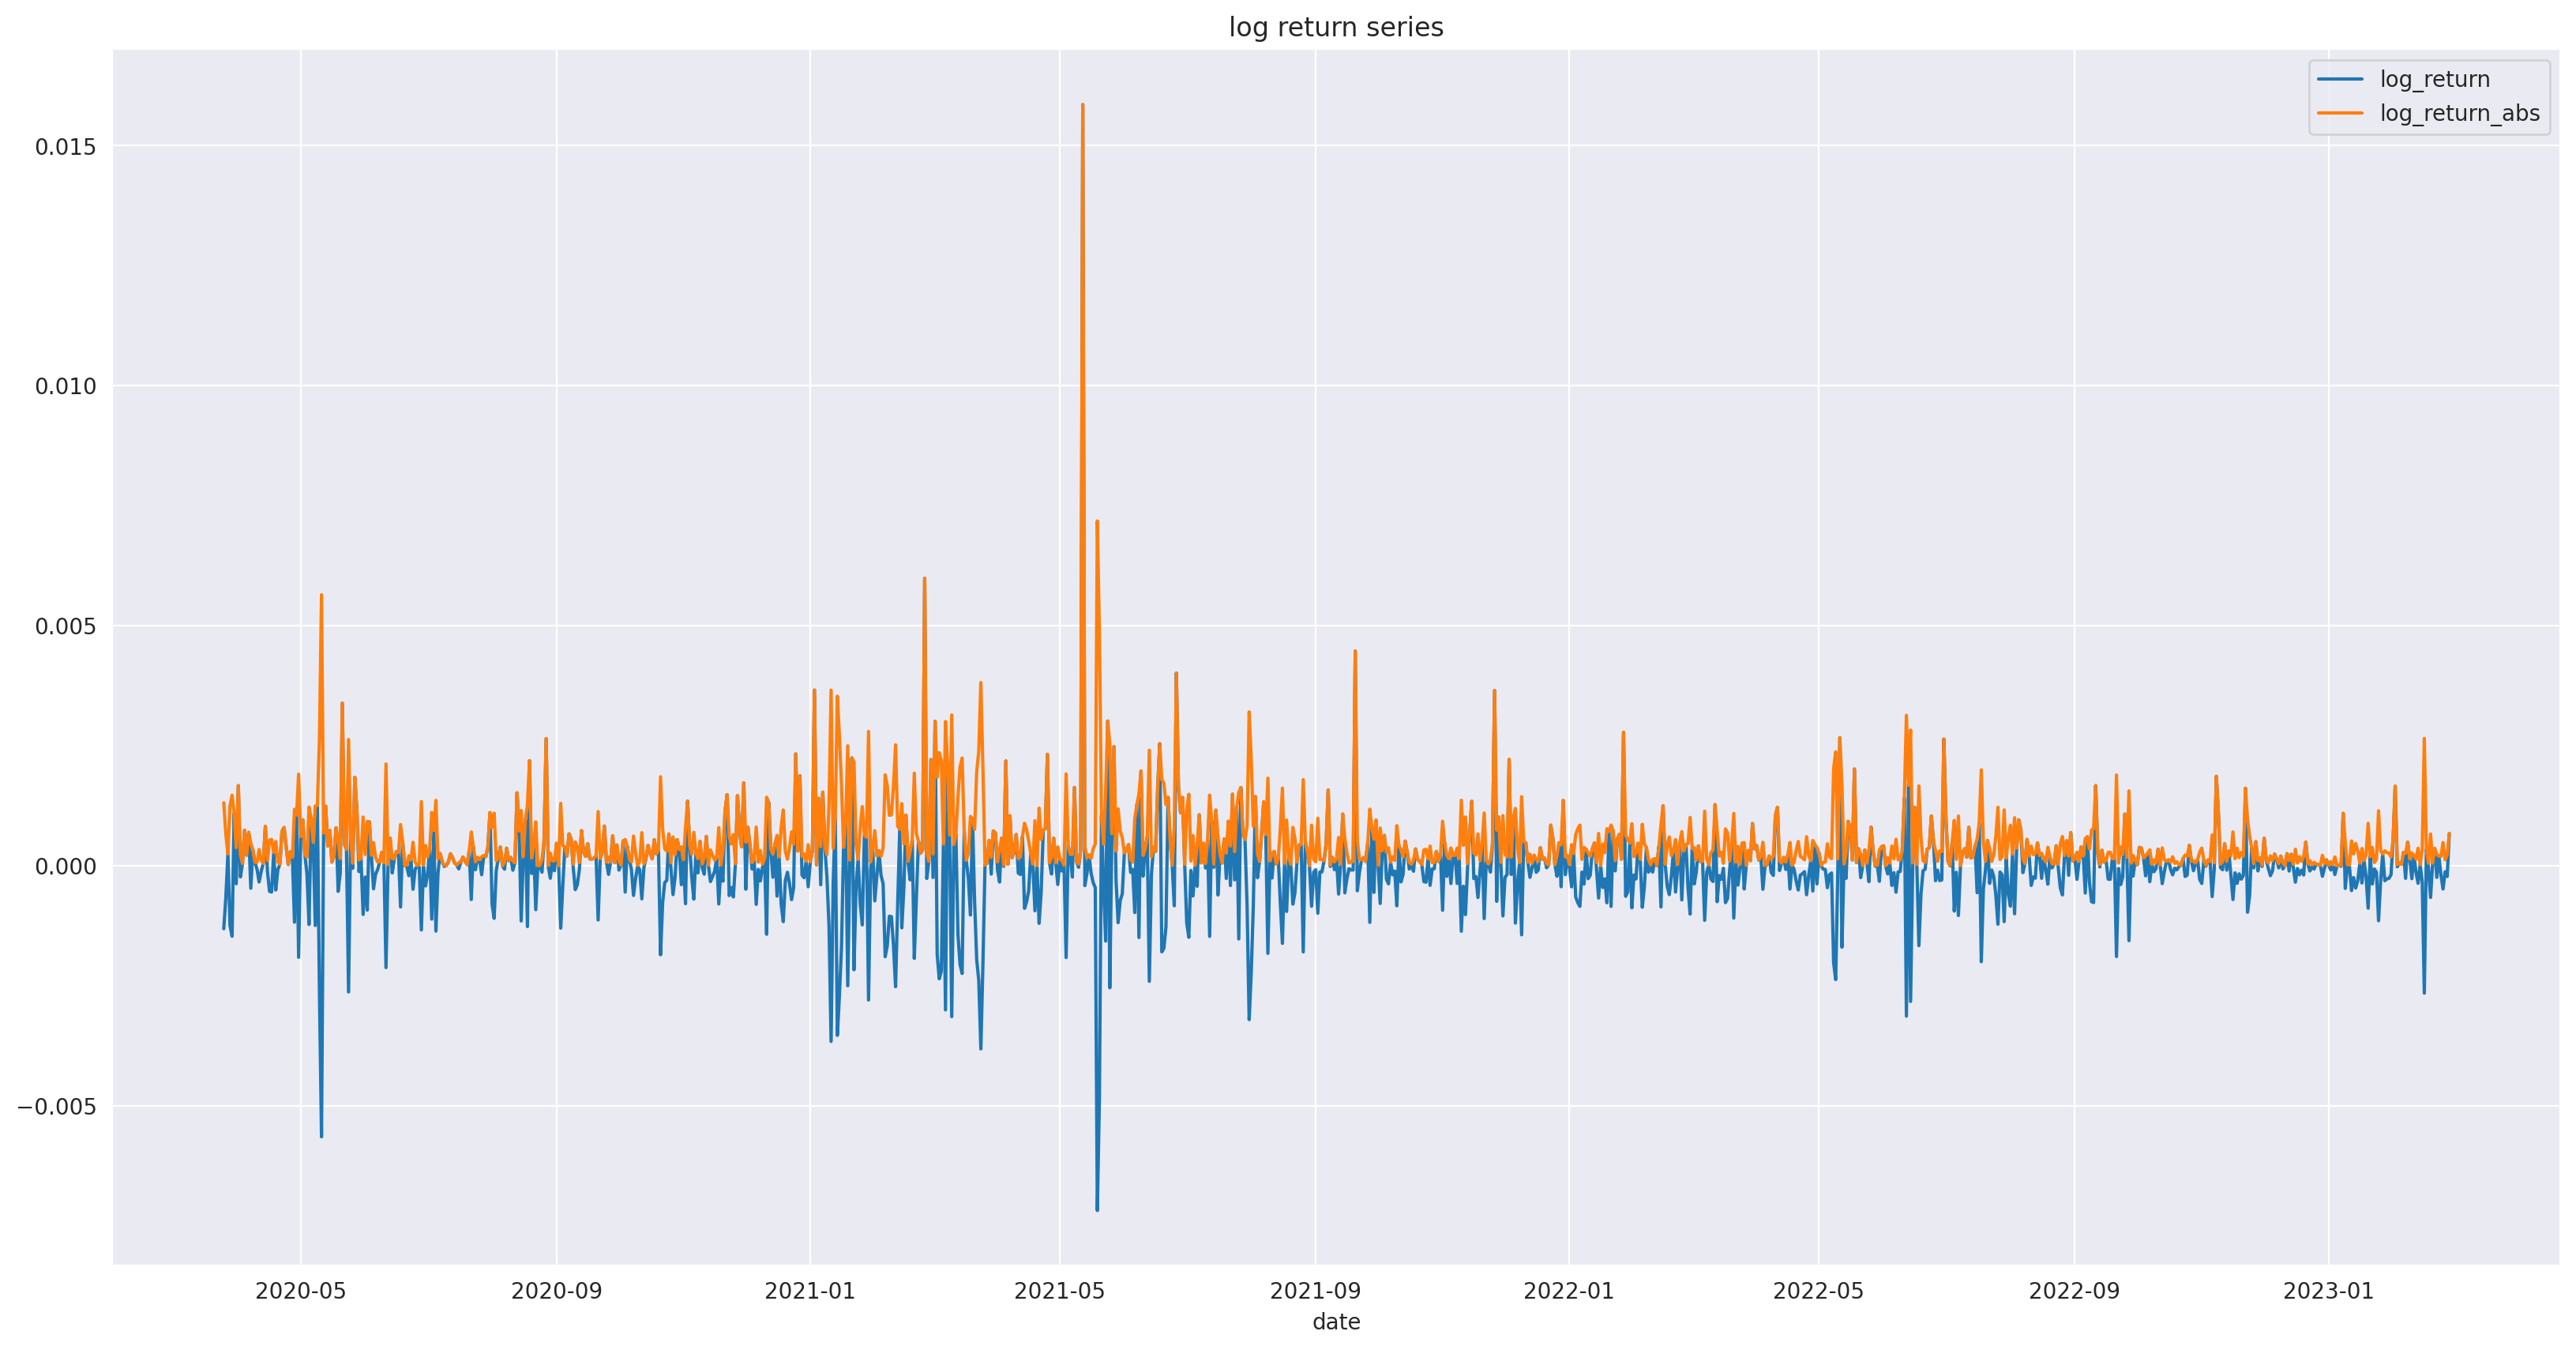

In [10]:
lr = pd.DataFrame(index=daily_prices.index)
lr['log_return'] = np.log(daily_prices['close'] / daily_prices['open'])
# lr = lr.groupby(lr.index.date).last()

lr['log_return_abs'] = np.abs(lr['log_return'])
lr['log_return_sign'] = np.sign(lr['log_return'])

lr[['log_return', 'log_return_abs']].plot(figsize=(20, 10), xlabel='date', title='log return series')

## Exploring trades features

In [11]:
# features = pd.read_csv('/kaggle/input/bybit-trades-accumulated/cum_1h.csv')
features = pd.read_feather('/kaggle/input/bybit-trades-accumulated/cum_1h.ftr')
features.drop('period', axis=1, inplace=True)
features.set_index('start', inplace=True)
features.index = pd.to_datetime(features.index)

# remove nan columns and none 
nan_threshold = 0.01
nan_counts = features.isnull().sum(axis=0)
valid_cols = nan_counts[nan_counts <= len(features) * nan_threshold].index.tolist()
features = features[valid_cols].dropna()

spectral_features = [col for col in features.columns if 'fourier' in col or 'wavelet' in col]
agg_features = [col for col in features.columns if col not in spectral_features]
# nan_cols = nan_counts[nan_counts > 0].index.tolist()
# nan_features = features[nan_cols]
# nan_features[nan_features.isnull()] = nan_features.rolling(window=24, min_periods=1, center=True).mean()
# features[nan_cols] = nan_features
features

,open,close,high,low,open_min,open_max,open_med,open_fqr,open_tqr,open_mean,open_std,open_skew,open_kurt,open_hmean,open_gmean,open_gstd,high_min,high_max,high_med,high_fqr,high_tqr,high_mean,high_std,high_skew,high_kurt,high_hmean,high_gmean,high_gstd,low_min,low_max,low_med,low_fqr,low_tqr,low_mean,low_std,low_skew,low_kurt,low_hmean,low_gmean,low_gstd,close_min,close_max,close_med,close_fqr,close_tqr,close_mean,close_std,close_skew,close_kurt,close_hmean,close_gmean,close_gstd,return_min,return_max,return_med,return_fqr,return_tqr,return_mean,return_std,return_skew,return_kurt,rel_return_min,rel_return_max,rel_return_med,rel_return_fqr,rel_return_tqr,rel_return_mean,rel_return_std,rel_return_skew,rel_return_kurt,log_return_min,log_return_max,log_return_med,log_return_fqr,log_return_tqr,log_return_mean,log_return_std,log_return_skew,log_return_kurt,abs_return_min,abs_return_max,abs_return_med,abs_return_fqr,abs_return_tqr,abs_return_mean,abs_return_std,abs_return_skew,abs_return_kurt,abs_rel_return_min,abs_rel_return_max,abs_rel_return_med,abs_rel_return_fqr,abs_rel_return_tqr,abs_rel_return_mean,abs_rel_return_std,abs_rel_return_skew,abs_rel_return_kurt,abs_log_return_min,abs_log_return_max,abs_log_return_med,abs_log_return_fqr,abs_log_return_tqr,abs_log_return_mean,abs_log_return_std,abs_log_return_skew,abs_log_return_kurt,gap_high_low_min,gap_high_low_max,gap_high_low_med,gap_high_low_fqr,gap_high_low_tqr,gap_high_low_mean,gap_high_low_std,gap_high_low_skew,gap_high_low_kurt,gap_high_low_hmean,gap_high_low_gmean,gap_high_low_gstd,gap_low_close_min,gap_low_close_max,gap_low_close_med,gap_low_close_fqr,gap_low_close_tqr,gap_low_close_mean,gap_low_close_std,gap_low_close_skew,gap_low_close_kurt,gap_high_close_min,gap_high_close_max,gap_high_close_med,gap_high_close_fqr,gap_high_close_tqr,gap_high_close_mean,gap_high_close_std,gap_high_close_skew,gap_high_close_kurt,open_fourier_sine_freqs,open_fourier_cosine_freqs,open_fourier_amplitudes,open_wavelet_approx_coeffs,open_wavelet_coeffs_level_1,open_wavelet_coeffs_level_2,high_fourier_sine_freqs,high_fourier_cosine_freqs,high_fourier_amplitudes,high_wavelet_approx_coeffs,high_wavelet_coeffs_level_1,high_wavelet_coeffs_level_2,low_fourier_sine_freqs,low_fourier_cosine_freqs,low_fourier_amplitudes,low_wavelet_approx_coeffs,low_wavelet_coeffs_level_1,low_wavelet_coeffs_level_2,close_fourier_sine_freqs,close_fourier_cosine_freqs,close_fourier_amplitudes,close_wavelet_approx_coeffs,close_wavelet_coeffs_level_1,close_wavelet_coeffs_level_2,return_fourier_sine_freqs,return_fourier_cosine_freqs,return_fourier_amplitudes,return_wavelet_approx_coeffs,return_wavelet_coeffs_level_1,return_wavelet_coeffs_level_2,rel_return_fourier_sine_freqs,rel_return_fourier_cosine_freqs,rel_return_fourier_amplitudes,rel_return_wavelet_approx_coeffs,rel_return_wavelet_coeffs_level_1,rel_return_wavelet_coeffs_level_2,log_return_fourier_sine_freqs,log_return_fourier_cosine_freqs,log_return_fourier_amplitudes,log_return_wavelet_approx_coeffs,log_return_wavelet_coeffs_level_1,log_return_wavelet_coeffs_level_2,abs_return_fourier_sine_freqs,abs_return_fourier_cosine_freqs,abs_return_fourier_amplitudes,abs_return_wavelet_approx_coeffs,abs_return_wavelet_coeffs_level_1,abs_return_wavelet_coeffs_level_2,abs_rel_return_fourier_sine_freqs,abs_rel_return_fourier_cosine_freqs,abs_rel_return_fourier_amplitudes,abs_rel_return_wavelet_approx_coeffs,abs_rel_return_wavelet_coeffs_level_1,abs_rel_return_wavelet_coeffs_level_2,abs_log_return_fourier_sine_freqs,abs_log_return_fourier_cosine_freqs,abs_log_return_fourier_amplitudes,abs_log_return_wavelet_approx_coeffs,abs_log_return_wavelet_coeffs_level_1,abs_log_return_wavelet_coeffs_level_2,gap_high_low_fourier_sine_freqs,gap_high_low_fourier_cosine_freqs,gap_high_low_fourier_amplitudes,gap_high_low_wavelet_approx_coeffs,gap_high_low_wavelet_coeffs_level_1,gap_high_low_wavelet_coeffs_level_2,gap_low_close_fourier_sine_freqs,gap_low_close_fourier_cosine_freqs,gap_low_close_fou

In [12]:
%%time
X_spectral = np.concatenate([np.stack(features[feature].tolist(), axis=0) for feature in tqdm(spectral_features)], axis=1)
X_spectral = (X_spectral - X_spectral.mean(axis=0)) / np.maximum(X_spectral.std(axis=0), 1)
X_spectral = np.clip(X_spectral, np.quantile(X_spectral, 0.001), np.quantile(X_spectral, 0.999))

100%|██████████| 78/78 [00:02<00:00, 26.34it/s]


CPU times: user 4.82 s, sys: 876 ms, total: 5.7 s
Wall time: 5.7 s


In [13]:
X_agg = features[[col for col in agg_features]]
X_agg = (X_agg - X_agg.mean(axis=0)) / np.maximum(X_agg.std(axis=0), 1)
X_agg = np.clip(X_agg, np.quantile(X_agg, 0.001), np.quantile(X_agg, 0.999))

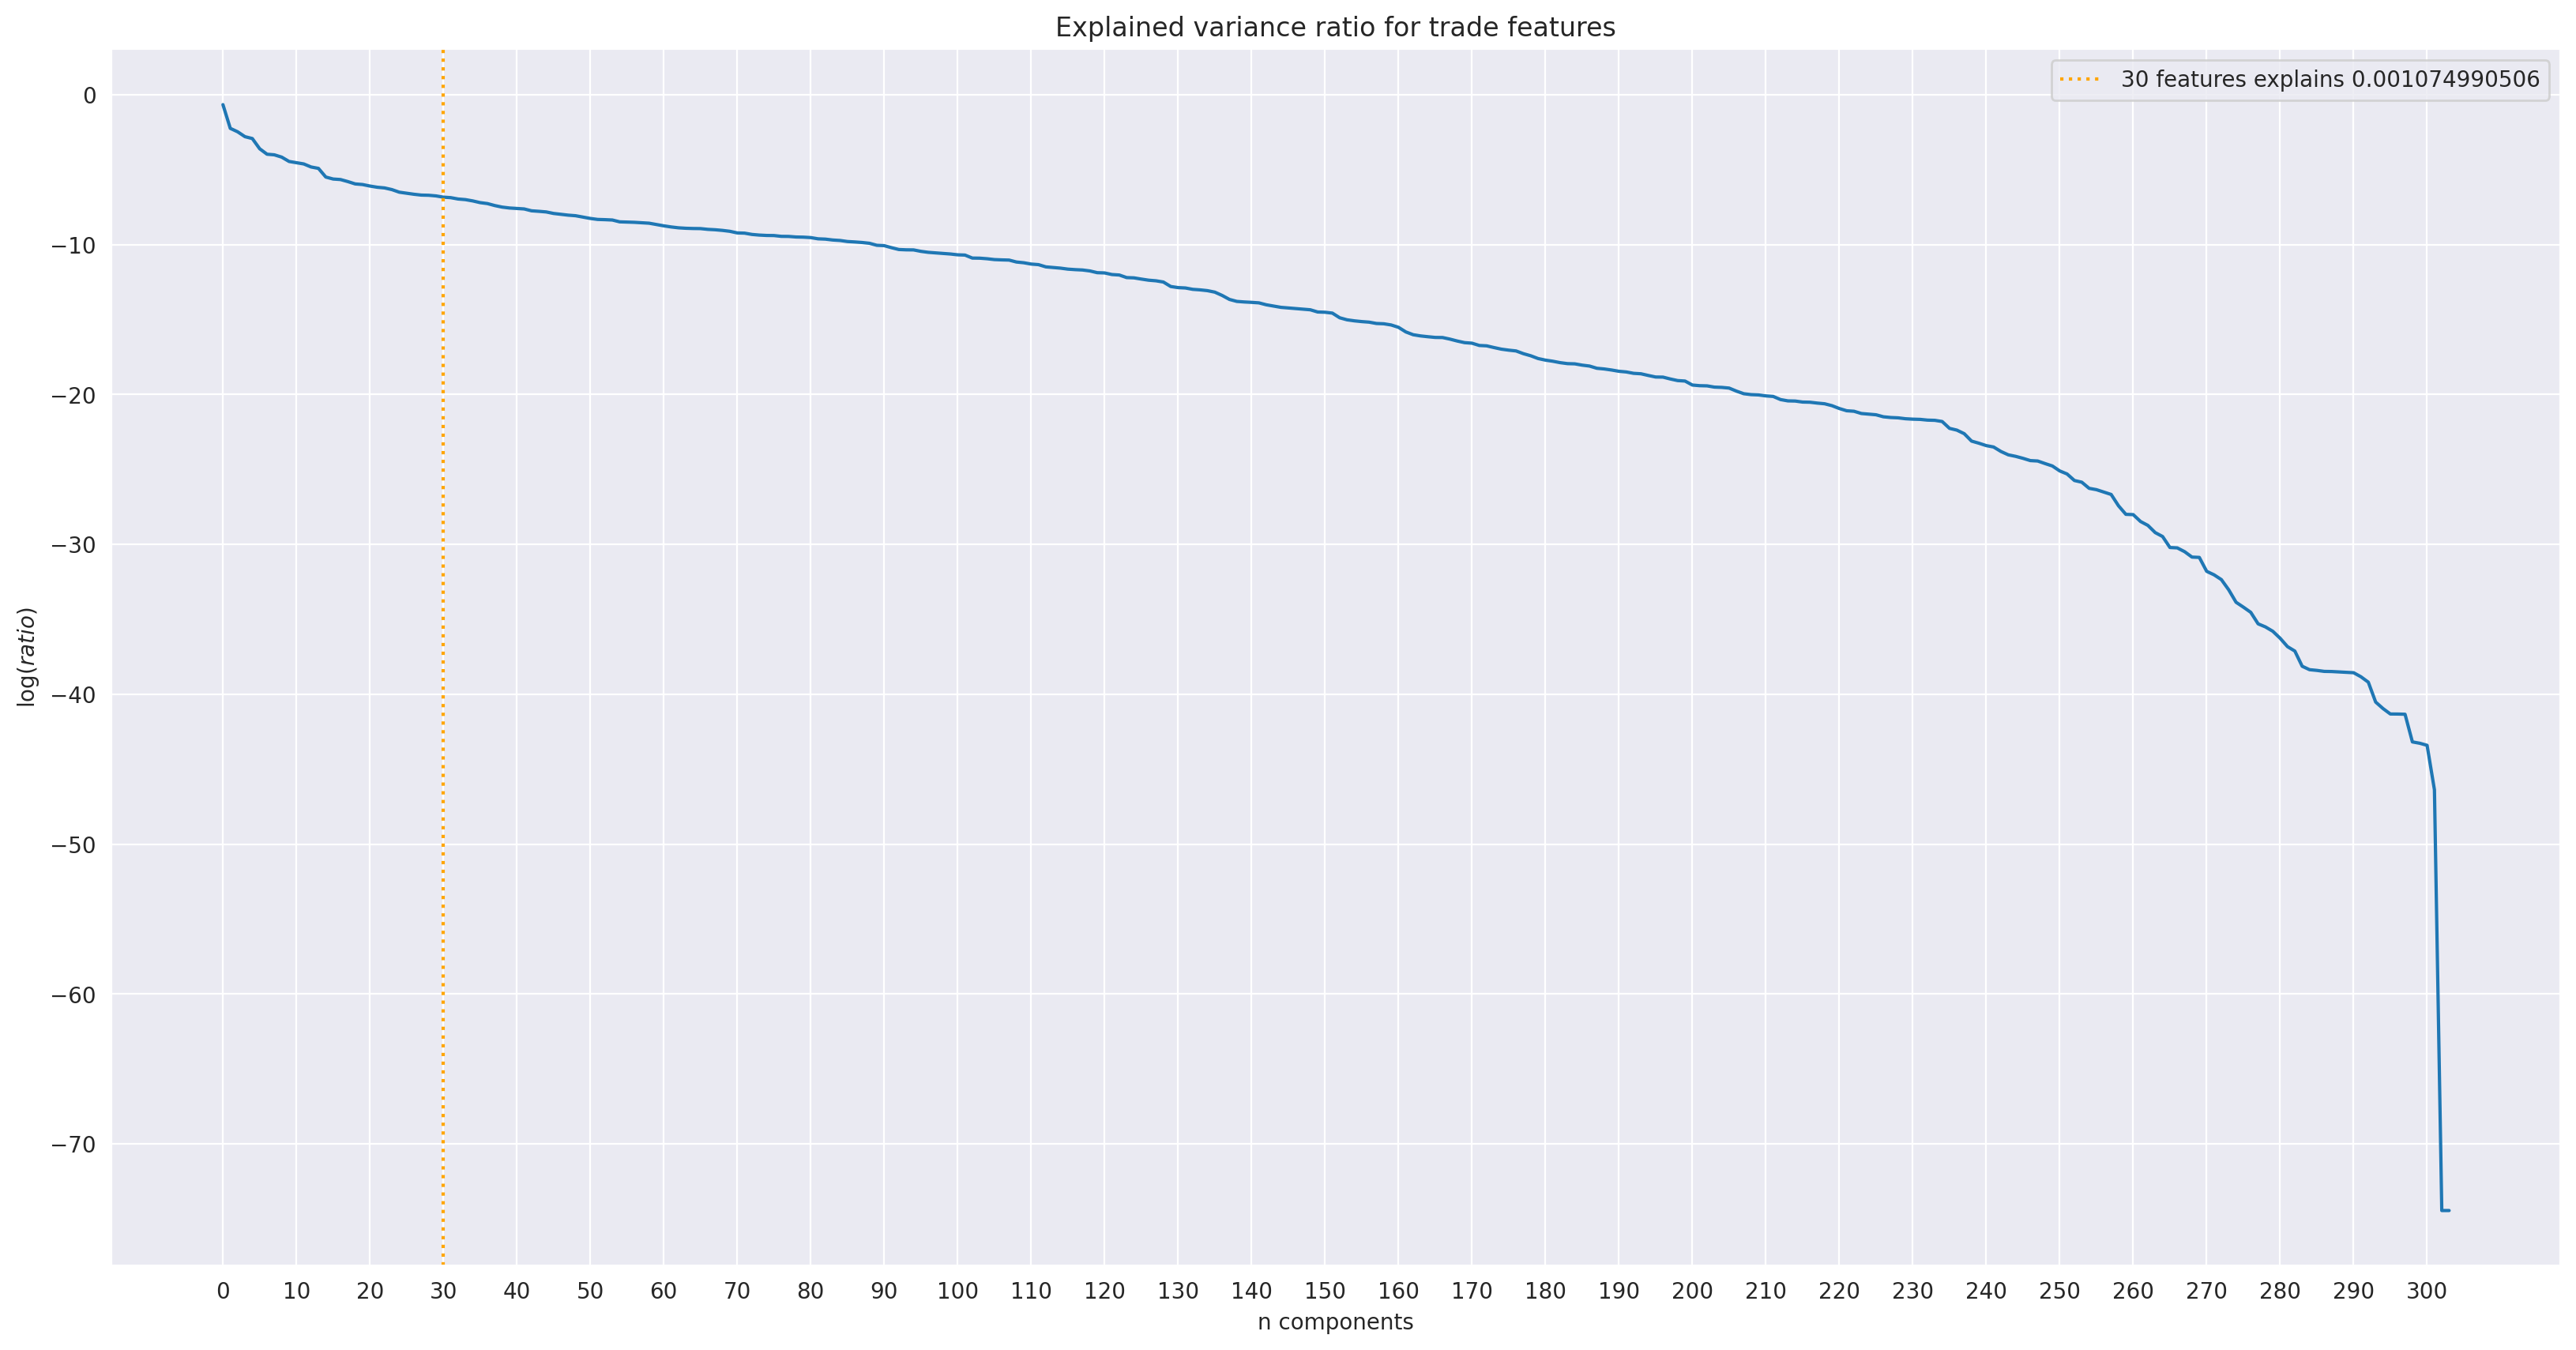

In [14]:
pca_agg = PCA(svd_solver='full').fit(X_agg)
n_agg_features = 30
fig = plt.figure(figsize=(20, 10))
sns.lineplot(np.log(pca_agg.explained_variance_ratio_))
plt.title('Explained variance ratio for trade features')
plt.xlabel('n components')
plt.ylabel(r'$\log(ratio)$')
plt.xticks(np.arange(len(pca_agg.explained_variance_ratio_), step=10))
plt.axvline(x=n_agg_features, linestyle='dotted', color='orange',
            label=fr'{n_agg_features} features explains {pca_agg.explained_variance_ratio_[n_agg_features]:.12f}')
plt.legend()
plt.show()

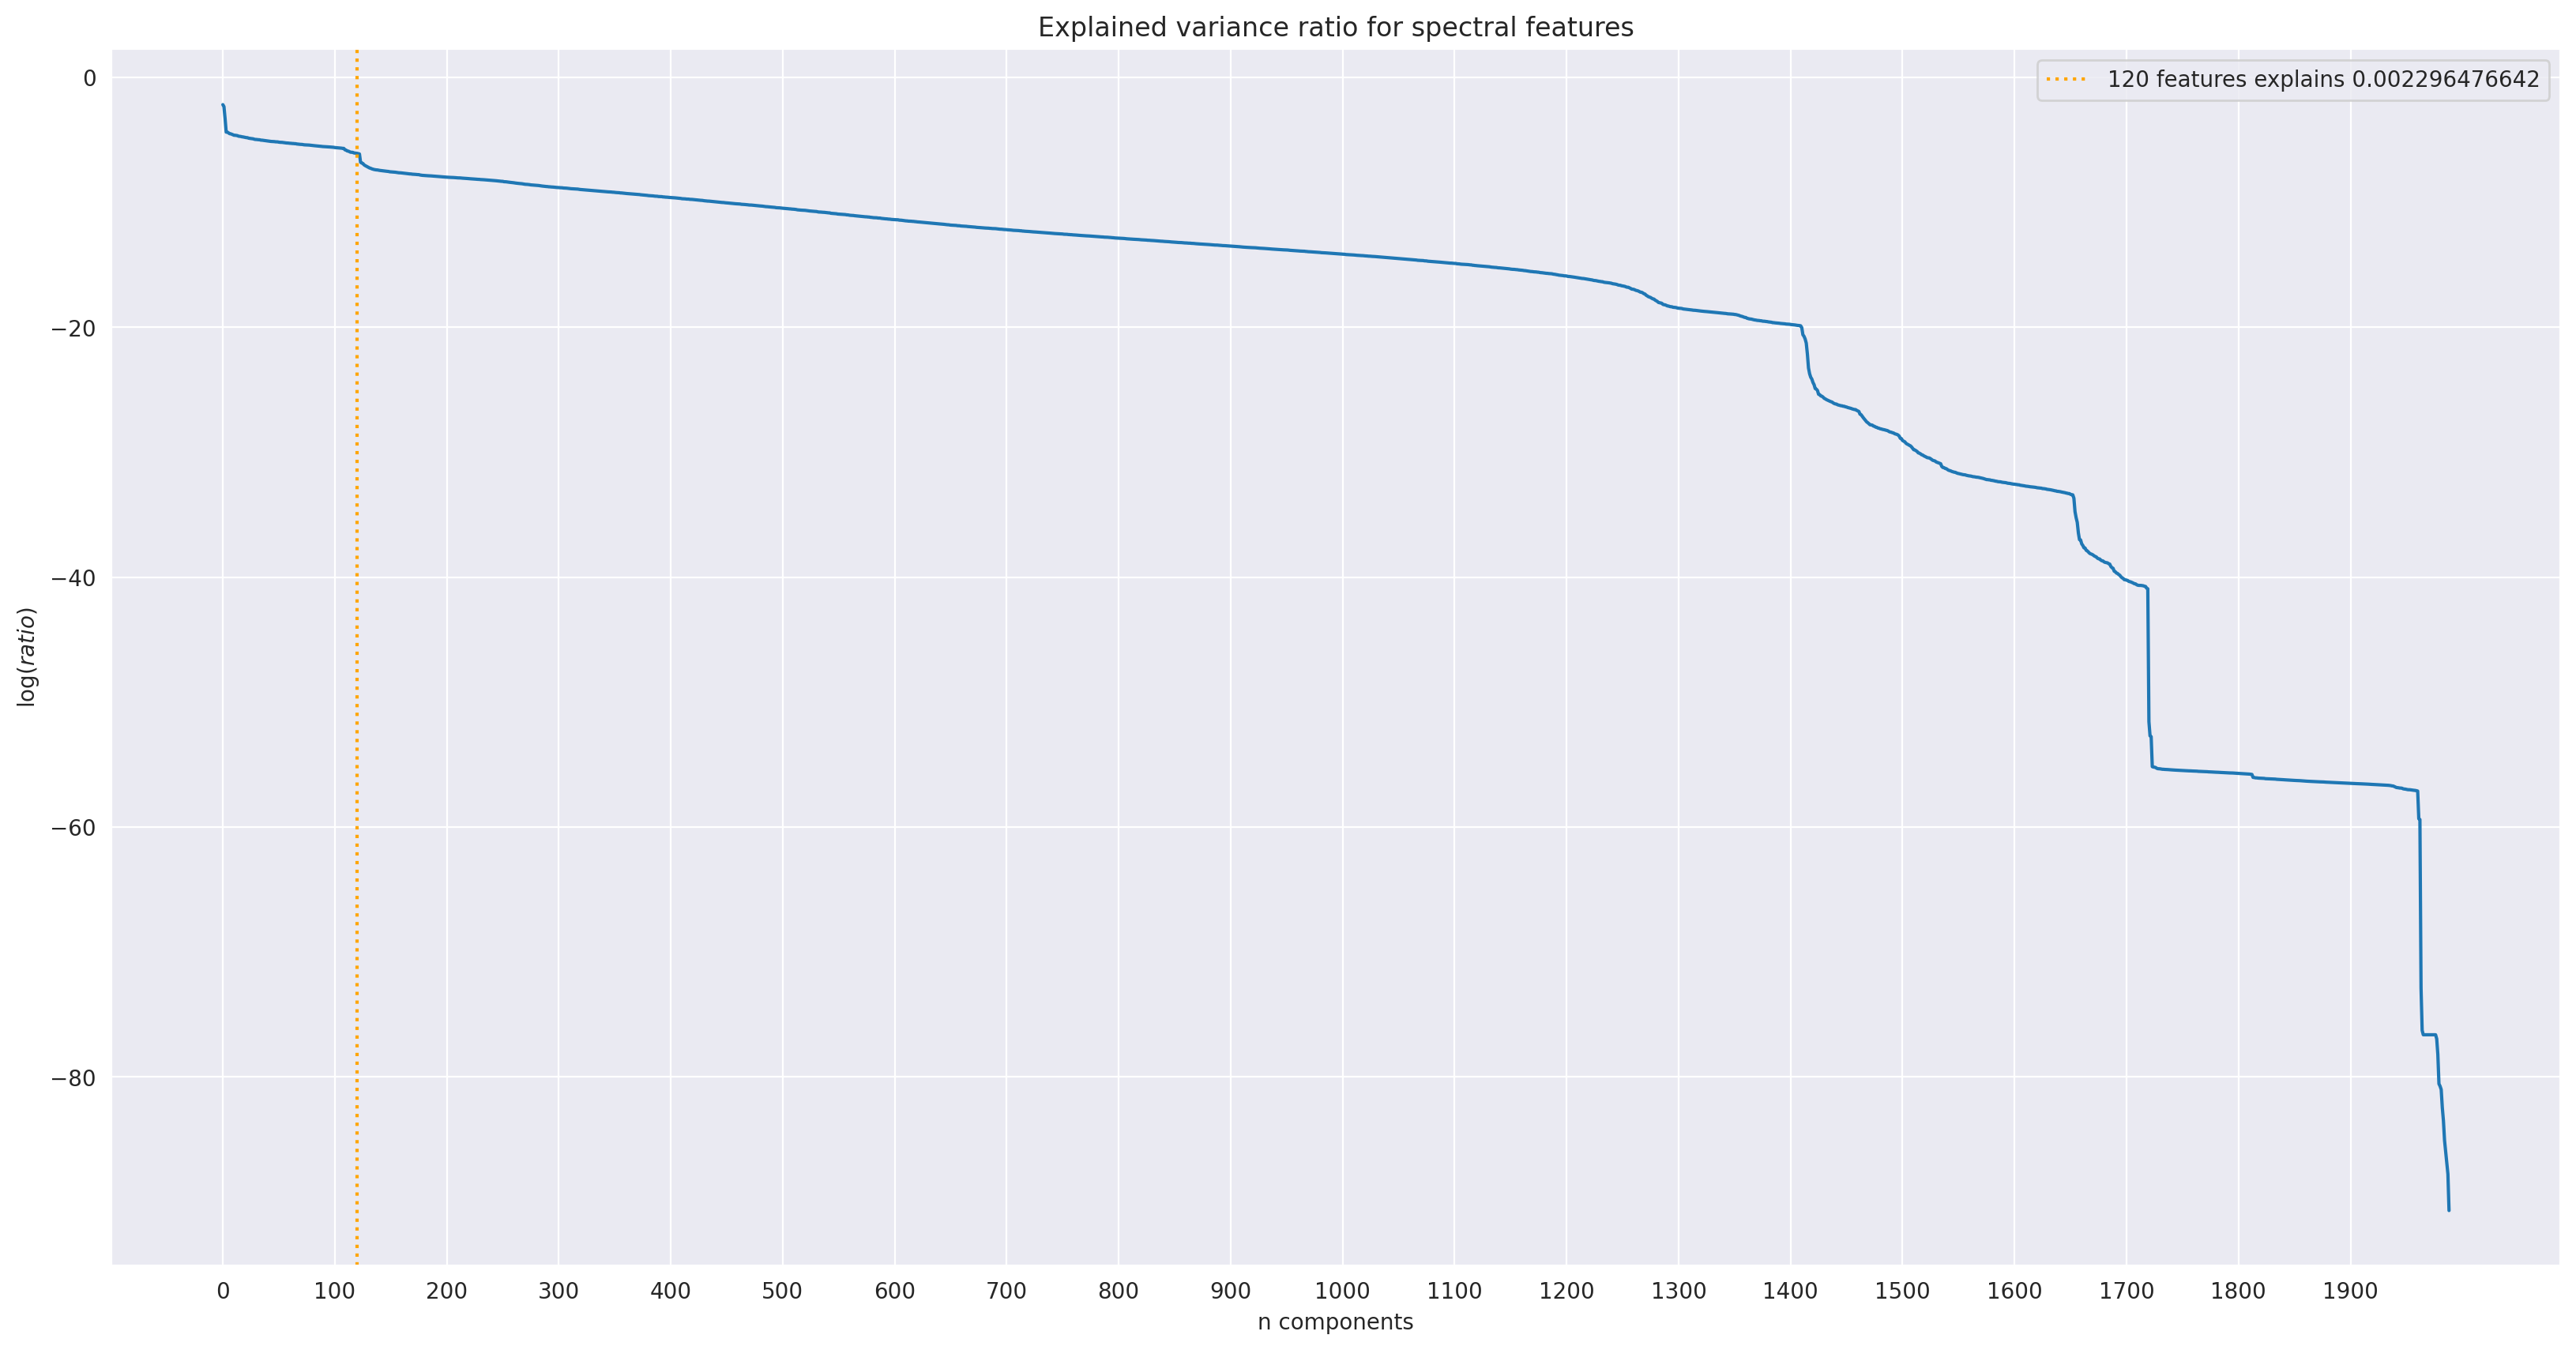

In [15]:
pca_spectral = PCA(svd_solver='full').fit(X_spectral)
n_spectral_features = 120
fig = plt.figure(figsize=(20, 10))
sns.lineplot(np.log(pca_spectral.explained_variance_ratio_))
plt.title('Explained variance ratio for spectral features')
plt.xlabel('n components')
plt.ylabel(r'$\log(ratio)$')
plt.xticks(np.arange(len(pca_spectral.explained_variance_ratio_), step=100))
plt.axvline(x=n_spectral_features, linestyle='dotted', color='orange',
            label=fr'{n_spectral_features} features explains {pca_spectral.explained_variance_ratio_[n_spectral_features]:.12f}')
plt.legend()
plt.show()

### Splitting to train/test

In [16]:
X = np.concatenate([pca_agg.transform(X_agg), pca_spectral.transform(X_spectral)], axis=1)[:-1]

y = np.log((features['close'] / features['open']).shift(-1).iloc[:-1])
y_norm = y.std()
y /= y_norm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, shuffle=False)

In [25]:
# plt.figure(figsize=(10, 30))
# target_corr = features.corrwith(features['close']).sort_values(ascending=False)
# sns.barplot(y=target_corr.index, x=target_corr.values)

In [26]:
# pd.DataFrame(X).corrwith(y)

## Learn sequence distribution

In [17]:
def classification_metrics(y_true, y_pred, threshold=0.5):
    y_label = y_pred > threshold
    metrics = {
        'accuracy': accuracy_score(y_true, y_label),
        'precision': precision_score(y_true, y_label),
        'recall': recall_score(y_true, y_label),
        'f1_score': f1_score(y_true, y_label),
        'roc_auc': roc_auc_score(y_true, y_pred),
        'log_loss': log_loss(y_true, y_pred)
    }
    return metrics

def print_classification_metrics(y_true, y_pred, model='model'):
    metrics = classification_metrics(y_true, y_pred)
    print(f'Classification metrics for {model}')
    for name, val in metrics.items():
        print(f'--- {name}: {val:.4f}')
        
def regression_metrics(y_true, y_pred):
    metrics = {
        'mse': np.mean((y_true - y_pred) ** 2),
        'msle': np.mean(np.log(np.abs((1 + y_true) / (1 + y_pred))) ** 2),
        'mae': np.mean(np.abs(y_true - y_pred)),
        'mape': np.mean(np.abs(y_true - y_pred) / np.maximum(1, y_true)),
        'r2': 1 - (y_true - y_pred).std() / (y_true - y_true.mean()).std(),
        'max_error': np.max(np.abs(y_true - y_pred))
    }
    return metrics

def print_regression_metrics(y_true, y_pred, model='model'):
    metrics = regression_metrics(y_true, y_pred)
    print(f'Regression metrics for {model}')
    for name, val in metrics.items():
        print(f'--- {name}: {val:.4f}')

### Logistic regression

In [18]:
log_reg = LogisticRegression(max_iter=500, C=0.01)
log_reg = log_reg.fit(X_train, y_train > 0)

print_classification_metrics(y_test > 0.5, log_reg.predict_proba(X_test)[:, 1], model='logistic regression')

Classification metrics for logistic regression
--- accuracy: 0.5509
--- precision: 0.2369
--- recall: 0.5092
--- f1_score: 0.3233
--- roc_auc: 0.5429
--- log_loss: 0.7366


### Zero mean prediction

In [32]:
print_regression_metrics(y_test, np.zeros_like(y_test))

Regression metrics for model
--- mse: 0.9856
--- msle: 0.7586
--- mae: 0.6349
--- mape: 0.5602
--- r2: 0.0000
--- max_error: 15.8496


### Linear regression

In [33]:
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train, y_train)

print_regression_metrics(y_test, lin_reg.predict(X_test), model='linear regression')

Regression metrics for linear regression
--- mse: 71752805990050.4688
--- msle: 32.9242
--- mae: 908488.7015
--- mape: 774243.5479
--- r2: -8532515.2414
--- max_error: 364687303.9428


### LightGBM

In [43]:
def create_model(params, train_data, test_data, iters=2000, logs=True, feature_frac=0.66):
    callbacks = [lgb.early_stopping(30, first_metric_only=True, verbose=False)]
    if logs:
        callbacks.append(lgb.log_evaluation(period=50))
    return lgb.train({
            'application': 'regression',
            'metric': {'l2', 'l1'},
            'boosting': 'goss',
            'learning_rate': params['lr'],
            'verbose': 1 if logs else -100,
            'max_depth': params['max_depth'],
            'num_leaves': params['num_leaves'],
            'num_threads': 4,
            'device': 'cpu',
            'min_data_in_leaf': 7,
            'feature_fraction': feature_frac,
#             'data_sample_strategy': 'goss',
            'top_rate': params['top_rate'],
            'other_rate': params['other_rate'],
            'lambda_l2': params['l2'],
            'max_bin': 64,
            'max_cat_threshold': 128,
            'max_cat_to_onehot': 4

        }, train_data, valid_sets=[test_data], num_boost_round=iters, callbacks=callbacks)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
val_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)

lgb_model = create_model({
    'lr': 1e-4,
    'max_depth': 5,
    'num_leaves': 7,
    'l2': 1e-6,
    'top_rate': 0.1,
    'other_rate': 0.3
}, train_data, val_data, logs=False)
print_regression_metrics(y_test, lgb_model.predict(X_test))

Regression metrics for model
--- mse: 0.9869
--- msle: 0.7675
--- mae: 0.6354
--- mape: 0.5619
--- r2: 0.0001
--- max_error: 15.8757


### Sequential distribution

In [50]:
class SequenceFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, features, target, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, index):
        return (torch.tensor(self.features[index : index + self.sequence_length], dtype=torch.float32),
               torch.tensor(self.target[index : index + self.sequence_length], dtype=torch.float32))
    
    
class Attention(torch.nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads=8, head_dim=32, dropout=0., bias=False):
        super().__init__()
        if head_dim is not None:
            self.head_dim = head_dim
            self.num_heads = embed_dim // head_dim
        else:
            self.num_heads = num_heads
            self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = torch.nn.LayerNorm(input_dim)
        self.to_q = torch.nn.Linear(input_dim, embed_dim, bias=bias)
        self.to_kv = torch.nn.Linear(input_dim, embed_dim * 2, bias=bias)
        self.to_out = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, input_dim, bias=bias),
            torch.nn.Dropout(dropout)
        )

    def forward(self, q, v=None, mask=None, **kwargs):
        # normalize inputs
        q_in = q
        q = self.norm(q)
        if v is None:
            v = q
        else:
            v = self.norm(v)

        # map inputs
        q = self.to_q(q)
        k, v = self.to_kv(v).chunk(2, dim=-1)

        b, n, dim = q.shape
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', d=self.head_dim), [q, k, v])
        q = q * self.scale

        dots = einsum(q, k, 'b h i d, b h j d -> b h i j')
        if mask is not None:
            if len(mask.shape) == 2:
                # masking paddings
                mask = mask.view(b, 1, 1, n)
            elif len(mask.shape) == 3:
                # masking sequence interconnections
                mask = mask.view(b, 1, n, n)
            dots = torch.where(mask, dots, torch.ones_like(dots) * float('-inf'))
        attn = torch.nn.functional.softmax(dots, dim=-1)
        out = torch.matmul(attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)

        return out + q_in    


    
class SeqGenerator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, model_type='gru'):
        super().__init__()
        self.noise_mapper = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim * 4),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim * 4, hidden_dim),
            torch.nn.SiLU()
        )
        if model_type == 'gru':
            self.cond_processor = torch.nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
            self.noise_processor = torch.nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'lstm':
            self.cond_processor = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) 
            self.noise_processor = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True) 
        elif model_type == 'transformer':
            self.cond_processor = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim),
                                                      torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers))
            self.noise_processor = torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers)
    
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
#             torch.nn.LayerNorm(hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
#             torch.nn.LayerNorm(hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, cond, noise):
        
        h_cond = self.cond_processor(cond)
        if isinstance(h_cond, tuple):
            h_cond = h_cond[0]
        h_cond = h_cond[:, -1:]
        
        h_noise = self.noise_processor(self.noise_mapper(noise))
        if isinstance(h_noise, tuple):
            h_noise = h_noise[0]
        
        h = torch.cat([h_noise, h_cond.repeat(1, h_noise.shape[1], 1)], dim=-1)
        output = self.fc(h)
        return output.squeeze(-1)

class SeqDiscriminator(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, num_layers, model_type='lstm'):
        super().__init__()
        self.input_mapper = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim)
        )
        if model_type == 'gru':
            self.seq_processor = torch.nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'lstm':
            self.seq_processor = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'transformer':
            self.seq_processor = torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers)
        self.fc = torch.nn.Sequential(torch.nn.utils.spectral_norm(torch.nn.Linear(hidden_dim, 1)))

    def forward(self, x):
        output = self.seq_processor(self.input_mapper(x.unsqueeze(-1)))
        if isinstance(output, tuple):
            output = output[0]
        output = self.fc(output[:, -1])
        return output.squeeze(-1)
    
def grad_norm(model):
    grads = [
        param.grad.detach().flatten()
        for param in model.parameters()
        if param.grad is not None
    ]
    norm = torch.cat(grads).norm()
    return norm

window = 24
pred_len = 6
sequence_length = window
condition_size = window - pred_len

batch_size = 128

# Prepare data
dataloader = torch.utils.data.DataLoader(SequenceFeaturesDataset(X_train, y_train, sequence_length), batch_size=batch_size, shuffle=True,
                                         pin_memory=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(SequenceFeaturesDataset(X_test, y_test, sequence_length), batch_size=batch_size, shuffle=False,
                                            pin_memory=True, num_workers=2)

targets = []
for i, (seq, target) in enumerate(val_dataloader):
    targets.append(target[:, condition_size - 1:-1])
targets = torch.cat(targets, dim=0)
print_regression_metrics(targets.detach().cpu().numpy(), torch.zeros_like(targets).detach().cpu().numpy(), model='zero prediction')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(dataloader, val_dataloder, model_type='transformer',
                nepochs=30, lr=1e-3, disc_lr=1e-4, hidden_dim=256, n_layers=8, disc_hidden_dim=128, disc_layers=2,
                disc_warmup=3, disc_w=1.0, mse_w=1.0):
    
    # Initialize models
    n_features = X.shape[1]
    gen = SeqGenerator(n_features, hidden_dim, 1, n_layers, model_type=model_type).to(device)
    disc = SeqDiscriminator(1, disc_hidden_dim, disc_layers, model_type=model_type).to(device)

    # Loss function and optimizers
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)
    gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_optimizer, gamma=0.95)

    disc_optimizer = torch.optim.SGD(disc.parameters(), lr=disc_lr)
    bce_fn = torch.nn.BCEWithLogitsLoss()

    # Training loop
    epochs = tqdm(range(nepochs), desc='Training')
    val_metrics = {}
    # Training loop
    for epoch in epochs:
        gen.train()
        disc.train()
        for batch_id, (seq, target) in enumerate(dataloader):
            seq, target = seq.to(device), target.to(device)

            # update generator
            gen_optimizer.zero_grad(set_to_none=True)

            condition = seq[:, :condition_size]
            target_sequences = target[:, condition_size-1:-1]
            pred_sequences = gen(condition, torch.randn(len(condition), pred_len, *condition.shape[2:]).type_as(condition))
            pred_std = pred_sequences.std().item()

            gen_mse = torch.mean((target_sequences - pred_sequences) ** 2)
            gen_loss = gen_mse
            if epoch >= disc_warmup:
                gen_loss = gen_loss * mse_w

            adv_loss = torch.tensor(0, device=device)
            if epoch >= disc_warmup:
                disc_logits = disc(pred_sequences)
                adv_loss = bce_fn(disc_logits, torch.ones_like(disc_logits))
                gen_loss += adv_loss * disc_w

            gen_loss.backward()
            model_grad_norm = grad_norm(gen)

            gen_optimizer.step()

            # Undate discriminator
            disc_optimizer.zero_grad(set_to_none=True)

            disc_preds = disc(torch.cat([target_sequences, pred_sequences.detach()], dim=0))
            disc_targets = torch.cat([torch.ones(len(target_sequences)), torch.zeros(len(pred_sequences))], dim=0).type_as(disc_preds)

            disc_loss = bce_fn(disc_preds, disc_targets)

            disc_loss.backward()
            disc_optimizer.step()

            metrics_str = ' '.join([f'val_{name}={val:.4f}' for name, val in val_metrics.items()])
            epochs.set_description(f'--- [({model_type}|{hidden_dim}|{n_layers}|{lr}),({disc_hidden_dim}|{disc_layers}|{disc_lr}),({mse_w},{disc_w})] Epoch {epoch+1}/{nepochs} [{batch_id+1}/{len(dataloader)}] '
                                   f'gen_loss={gen_loss.item():.4f} gen_mse={gen_mse.item():.4f} gen_adv={adv_loss.item():.4f} disc_loss={disc_loss.item():.4f} '
                                   f'{metrics_str} '
                                   f'pred_std={pred_std:.4f} grad_norm={model_grad_norm.item():.4f}', refresh=True)

        gen_scheduler.step()

        gen.eval()
        disc.eval()
        preds, targets = [], []
        for i, (seq, target) in enumerate(val_dataloader):
            seq, target = seq.to(device), target.to(device)
            condition = seq[:, :condition_size]
            target_sequences = target[:, condition_size-1:-1]
            with torch.no_grad():
                pred_sequences = gen(condition, torch.randn(len(condition), pred_len, *condition.shape[2:]).type_as(condition))
            preds.append(pred_sequences.detach().cpu())
            targets.append(target_sequences.detach().cpu())
        preds, targets = torch.cat(preds, dim=0).numpy(), torch.cat(targets, dim=0).numpy()
        val_metrics = regression_metrics(targets, preds)
        
    return gen


train_model(dataloader, val_dataloader, model_type='lstm', nepochs=30, disc_w=0.0)
train_model(dataloader, val_dataloader, model_type='gru', nepochs=30, disc_w=0.0)
gen = train_model(dataloader, val_dataloader, model_type='transformer', nepochs=30, disc_w=0.0)

--- [(lstm|256|8|0.001),(128|2|0.0001),(1.0,1.0)] Epoch 1/30 [60/60] gen_loss=1.2842 gen_mse=1.2842 gen_adv=0.0000 disc_loss=0.6960  pred_std=0.0004 grad_norm=0.1114:   0%|          | 0/30 [00:03<?, ?it/s]


KeyboardInterrupt: 

Simulation: 100%|██████████| 7/7 [00:00<00:00, 83.46it/s]


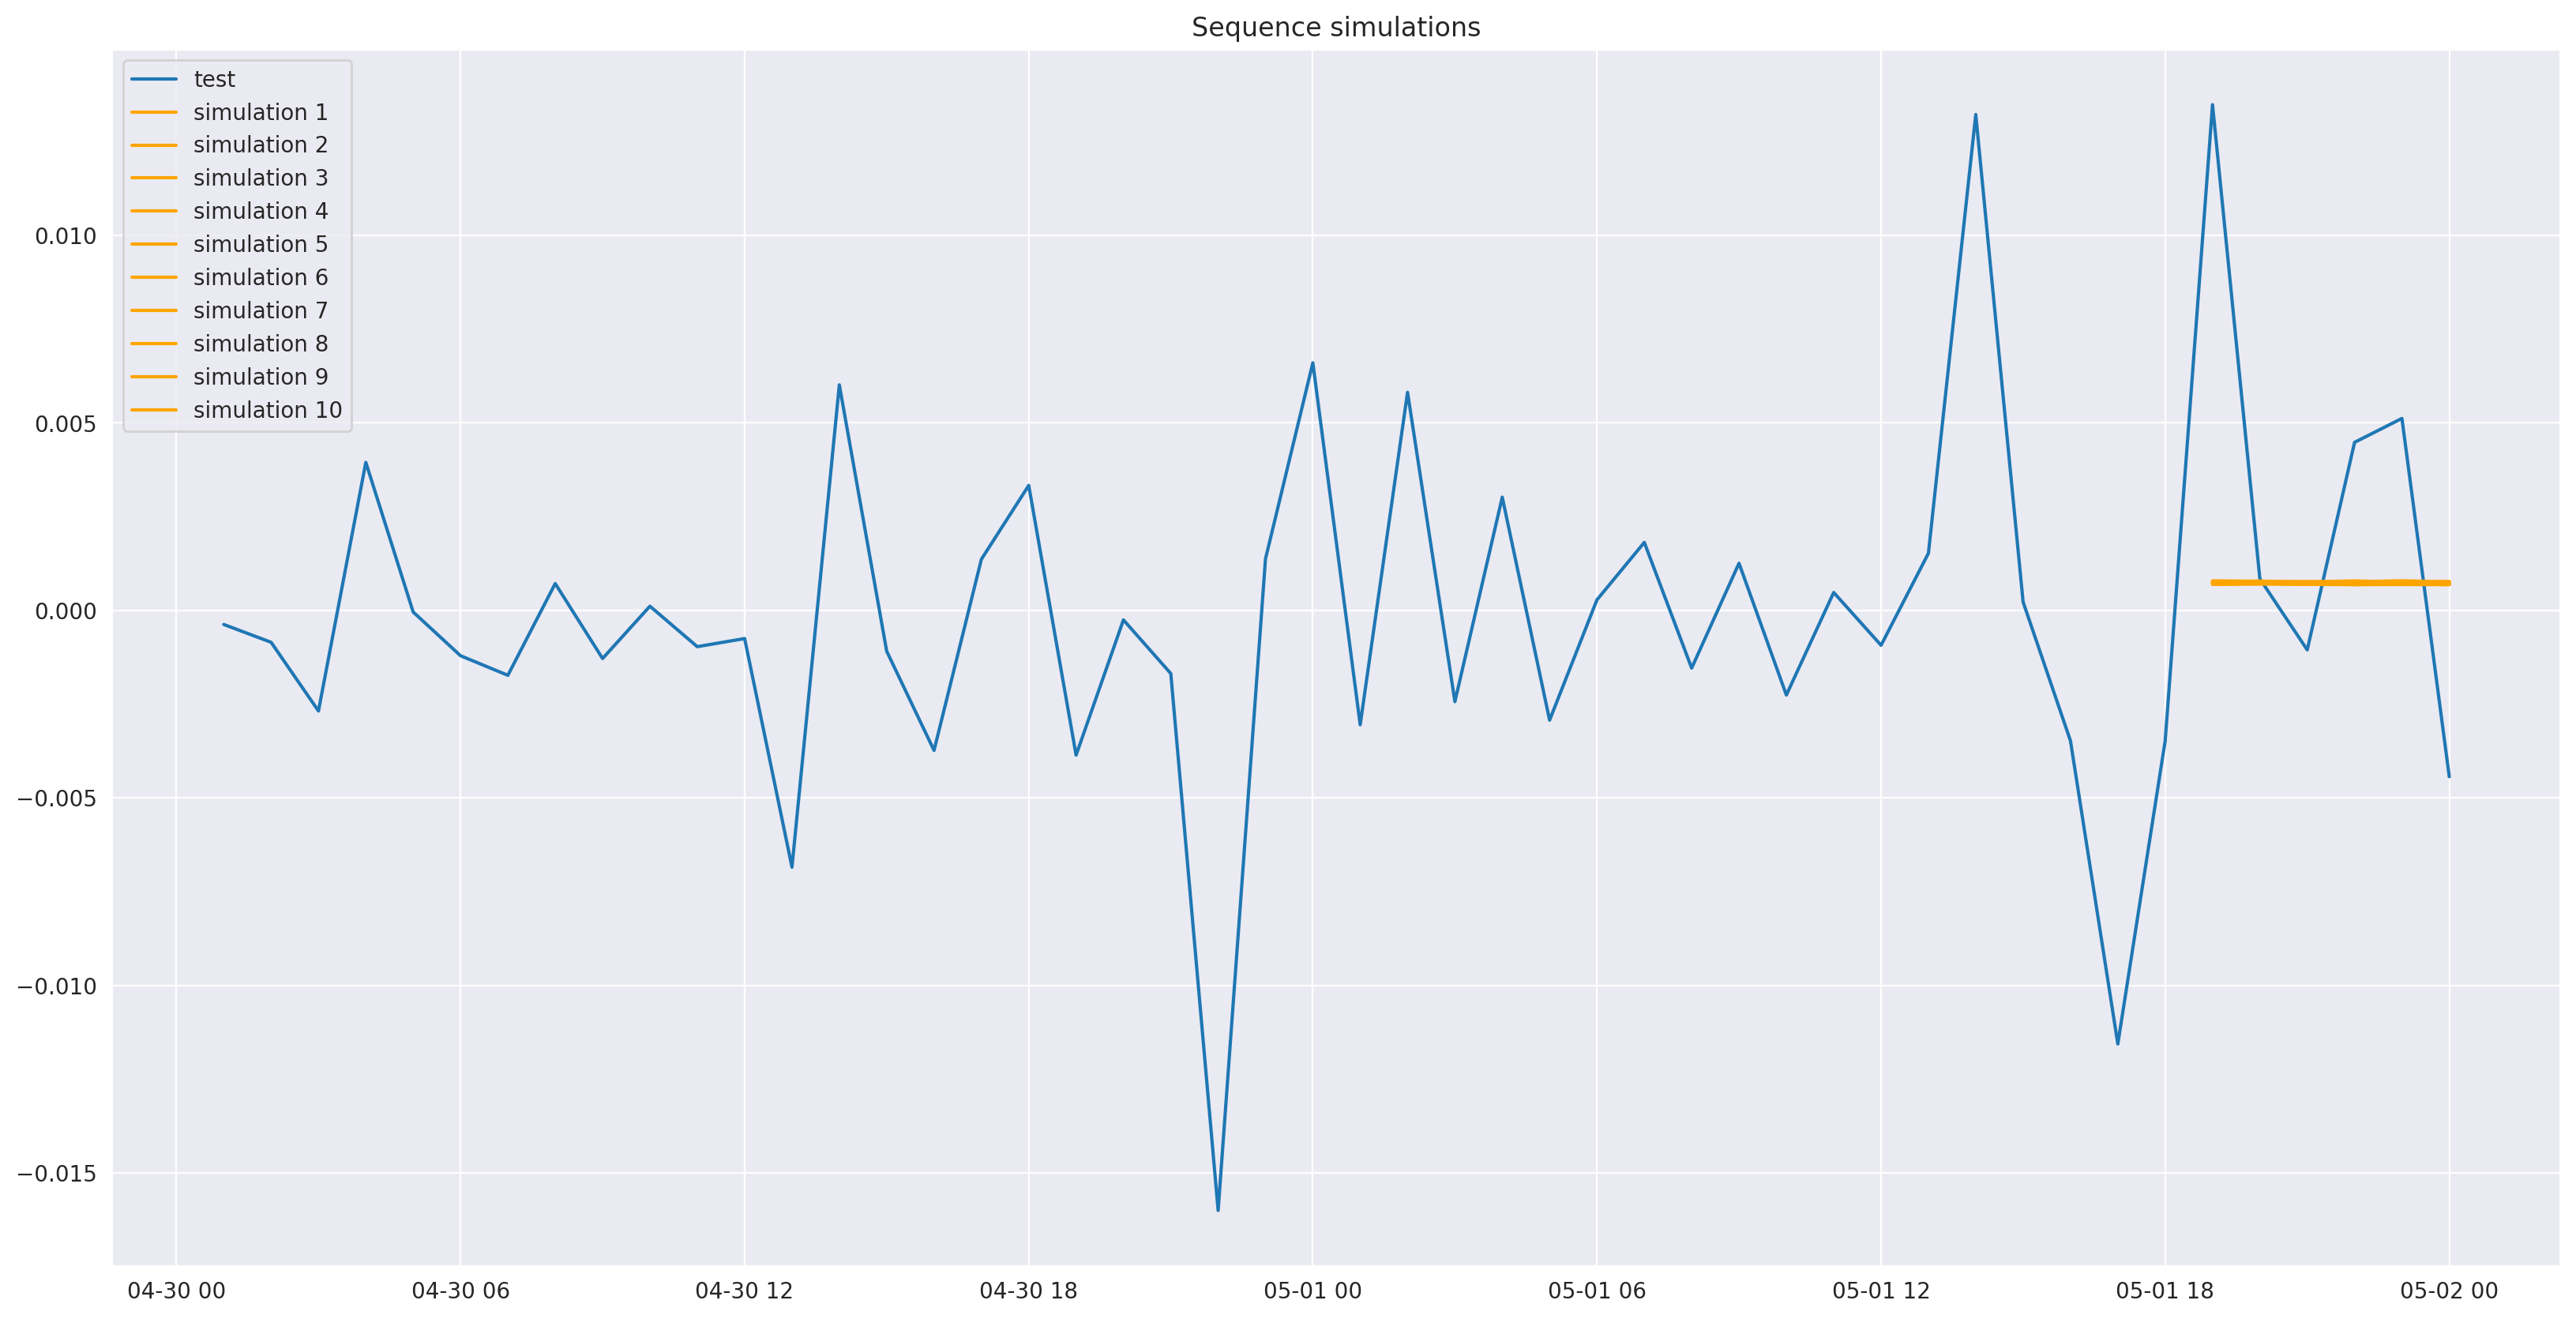

In [51]:
gen.eval()

num_estimations = 1000
local_window = window * 2

offset = randint(0, len(y_test) - local_window)
window_series = y_test[offset: offset + local_window]
head_series = window_series[-pred_len:]

condition = torch.tensor(X_test[offset + local_window - window:offset + local_window - pred_len], 
                         dtype=torch.float32, device=device).unsqueeze(0)

simulations = []
for batch_id in tqdm(range(max(num_estimations // batch_size, 1)), desc='Simulation'):
    with torch.no_grad():
        pred_sequences = gen(condition.repeat(batch_size, 1, 1), torch.randn(batch_size, pred_len, *condition.shape[2:]).type_as(condition))
    simulations.append(pred_sequences)
simulations = torch.cat(simulations, dim=0)

fig = plt.figure(figsize=(20, 10))
time_index = features['open'].shift(-1).iloc[len(y_train) + offset: len(y_train) + offset + local_window].index
plt.plot(time_index, window_series * y_norm, label='test')

for idx, simulation in enumerate(choices(simulations, k=10)):
    plt.plot(time_index[-pred_len:], simulation.detach().cpu().numpy() * y_norm, label=f'simulation {idx+1}', color='orange')
plt.legend()
plt.title(f'Sequence simulations')
plt.show()